# Physical Model

In [101]:
import os
import sys
sys.path.append("./src")
from soil_models import *
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 16})

data_dir='./data/'
fig_dir='./figures/'

harper_met = os.path.join(data_dir, 'NewportSalop_merged.csv')
reg_met = os.path.join(data_dir, 'met_newport.csv')
phy_data = os.path.join(data_dir, 'Soil_phy.csv')
phy_data_interpolate = os.path.join(data_dir, 'interpolated_soil_phy.csv')

# Data

## Time information

In [102]:
## Index on the hour
hourly_index = [7,67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]
hourly_index = np.array(hourly_index)

## Soil physical data

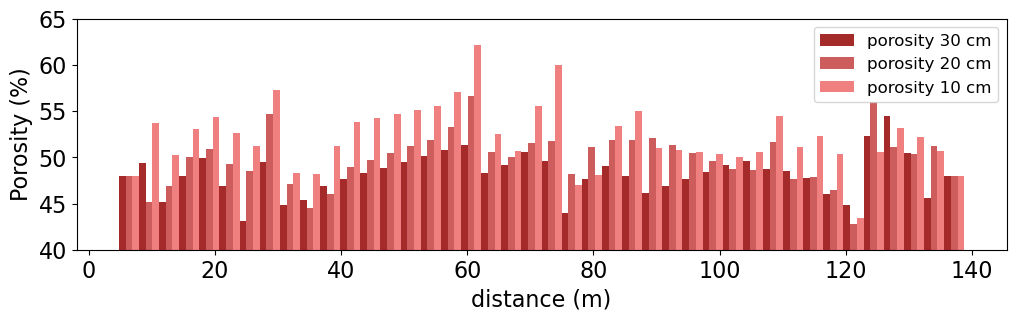

In [103]:
### Read the interpolated data
soil_phy = pd.read_csv(phy_data_interpolate)
interp_porosity_10cm = soil_phy['interp_porosity_10cm'].values
interp_porosity_20cm = soil_phy['interp_porosity_20cm'].values
interp_porosity_30cm = soil_phy['interp_porosity_30cm'].values
interp_bulk_density_10cm = soil_phy['interp_bulk_density_10cm'].values
interp_bulk_density_20cm = soil_phy['interp_bulk_density_20cm'].values
interp_bulk_density_30cm = soil_phy['interp_bulk_density_30cm'].values

# plt.figure(figsize=(12, 5))
# plt.plot(np.arange(50)*3.19, interp_bulk_density_30cm, label='density 30 cm', color='b')  
# plt.plot(np.arange(50)*3.19, interp_bulk_density_20cm, label='density 20 cm', color='g')
# plt.plot(np.arange(50)*3.19, interp_bulk_density_10cm, label='density 10 cm', color='r')
# plt.scatter(np.arange(50)*3.19, interp_bulk_density_30cm,  color='b', s=30)
# plt.scatter(np.arange(50)*3.19, interp_bulk_density_20cm,  color='g', s=30)
# plt.scatter(np.arange(50)*3.19, interp_bulk_density_10cm,  color='r', s=30)


# plt.xlabel("distance (m)", fontsize = 16)
# plt.ylabel("Bulk density (g/cm3)", fontsize = 16)
# plt.legend()

plt.figure(figsize=(12, 3))
bar_width = 3.19
x = np.arange(50) * bar_width
plt.ylim(40, 65)
plt.bar(x[2:44] - bar_width/3, interp_porosity_30cm[2:44], width=bar_width/3, label='porosity 30 cm', color='brown', align='center')
plt.bar(x[2:44], interp_porosity_20cm[2:44], width=bar_width/3, label='porosity 20 cm', color='indianred', align='center')
plt.bar(x[2:44] + bar_width/3, interp_porosity_10cm[2:44], width=bar_width/3, label='porosity 10 cm', color='lightcoral', align='center')

plt.xlabel("distance (m)", fontsize=16)
plt.ylabel("Porosity (%)", fontsize=16)
plt.legend(loc='upper right', fontsize=12)


## PSD and time

In [104]:
with h5py.File(os.path.join(data_dir, 'integrated_psd.hdf5'), 'r') as f:
    int_PSD = f['int_PSD'][:]
    freq = f['freq'][:]
    file_list = f['file_list'][:]

## Mean PSD over channels
ave_psd=np.mean(int_PSD[0:44], axis=0) + 0.0009

acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]

xax=hourly_index[::6]
tax=acqu_time[hourly_index[::6]]
hrax=[dt.strftime('%H') for dt in tax]

## dV/V

In [105]:
with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio_3iterations.h5'), 'r') as f:
# with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio.h5'), 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]
print(deratio_dvv.shape)

interp_f = interp1d(np.arange(0,2408,5), deratio_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(np.arange(2408))
dvv_all = gaussian_filter1d(interp_dvv, sigma=4, axis=-1)
# dvv_all = interp_dvv

(50, 482)


## Damage index

In [106]:
damage_index =pd.read_csv(os.path.join(data_dir, 'damage_index.csv'))
damage_index = damage_index['dvv_varibility'].values
damage_index[18-6]

0.5610497851741607

## Regional Met data

In [107]:
### regional weather data
csv_file = pd.read_csv(reg_met)
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
humidity = csv_file['Humidity'].to_numpy()

air_temp_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp) * 30, 30), air_temp)
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
humidity_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(humidity) * 30, 30), humidity)


## Met data at farm

In [108]:
### Read the site weather data
csv_file = pd.read_csv(harper_met, low_memory=False).dropna(axis='columns', how='all')
j = 32   ## index of the beginning time
humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()
air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall = csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)
rain_diff[np.where(rain_diff<0)]=0

interpx = np.arange(2408)
interp_f = interp1d(hourly_index[1:], humidity, bounds_error=False, fill_value="extrapolate")
interp_humidity = interp_f(interpx)
interp_f = interp1d(hourly_index[1:], soil_temp_10, bounds_error=False, fill_value="extrapolate")
interp_temp10 = interp_f(interpx)

air_temp_add1 = np.insert(air_temp, 0, 12)
air_temp_local = np.interp(interpx, np.arange(0, len(air_temp_add1) * 60, 60), air_temp_add1)

### use dew point temperature to calculate the relative humidity
dew_temp_add1 = np.insert(dew_temp, 0, 9)
dew_temp_local = np.interp(np.arange(0, 2408), np.arange(0, len(dew_temp_add1) * 60, 60), dew_temp_add1)
r_humidity = 100 * np.exp((17.27 * dew_temp_local) / (dew_temp_local + 237.3)) / np.exp((17.27 * air_temp_local) / (air_temp_local + 237.3))

# Compare met data

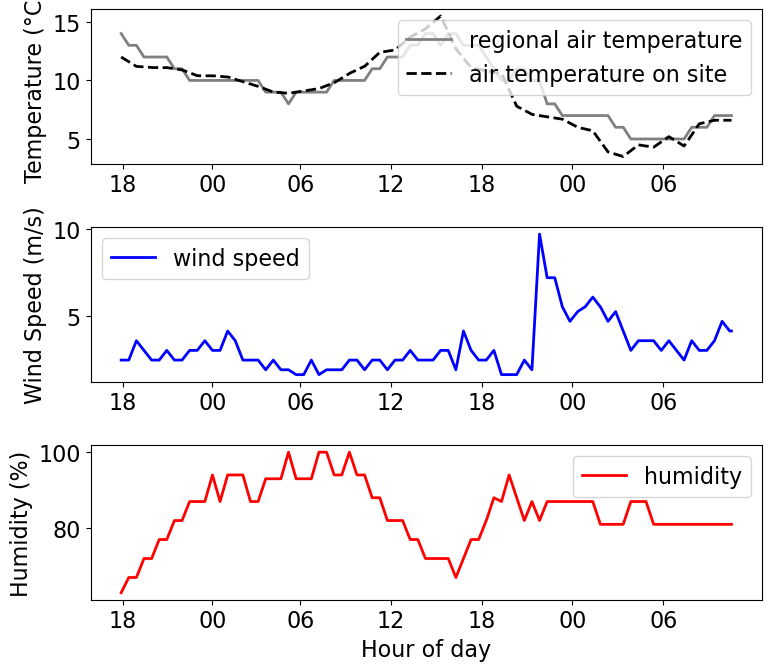

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 7), tight_layout=True)

# Plot regional air temperature and air temperature on site
ax1.plot(np.arange(2408), air_temp_interpolated, label='regional air temperature', color='gray', lw=2)
ax1.plot(np.arange(2408), air_temp_local, label='air temperature on site', color='k', linestyle='--', lw=2)
ax1.set_ylabel("Temperature (°C)", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=16)
ax1.legend()

# Plot wind speed
ax2.plot(np.arange(2408), wind_speed_interpolated, label='wind speed', color='blue', lw=2)
ax2.set_ylabel("Wind Speed (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=16)
ax2.legend()

# Plot humidity
ax3.plot(np.arange(2408), humidity_interpolated, label='humidity', color='r', lw=2)
ax3.set_xlabel("Hour of day", fontsize=16)
ax3.set_ylabel("Humidity (%)", fontsize=16)
ax3.set_xticks(xax)
ax3.set_xticklabels(hrax, fontsize=16)
ax3.legend()

plt.show()

# Compare PSD with rainfall

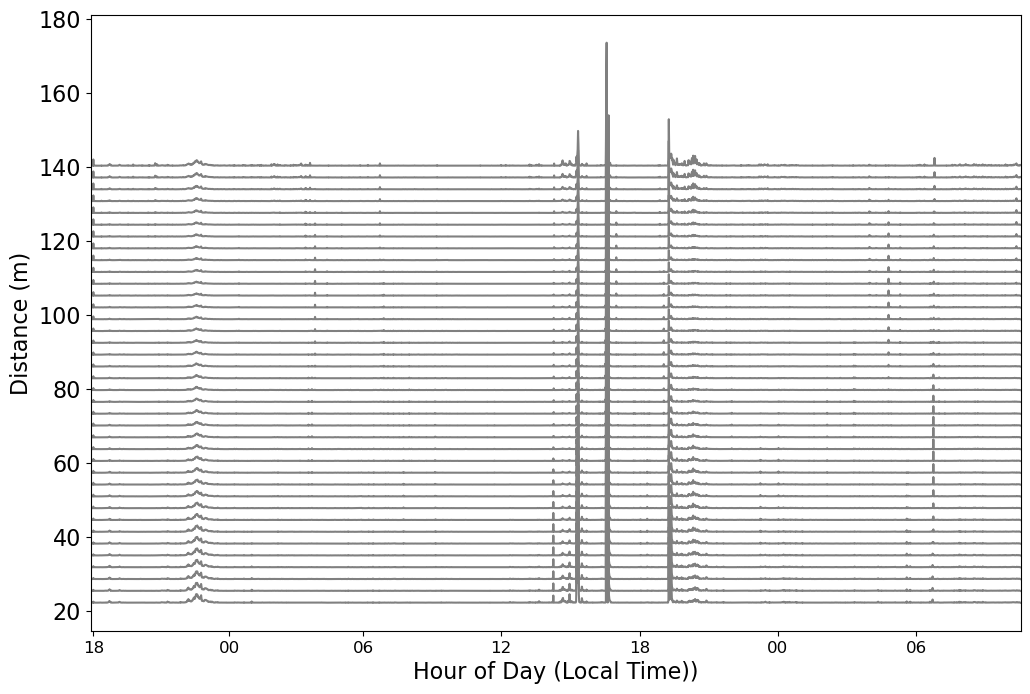

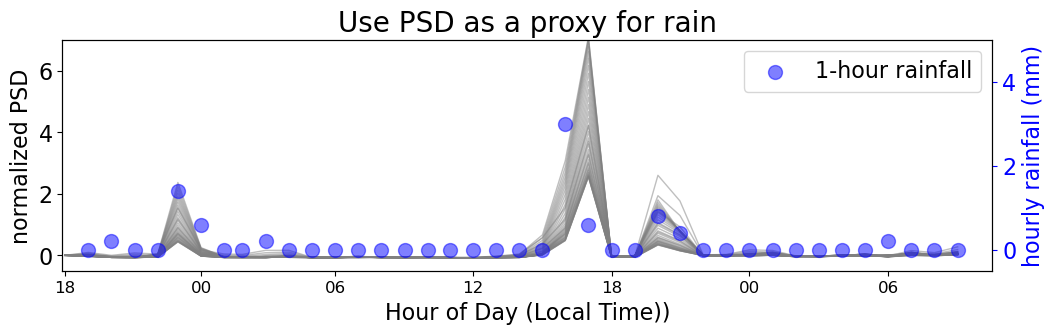

In [110]:
### Plot1
plt.figure(figsize=(12, 8))
plt.xlabel("Hour of Day (Local Time))", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)
plt.xlim(0, ave_psd.shape[-1])

for ch in np.arange(7,45):
    plt.plot(np.arange(2408), int_PSD[ch, :]* 20 + ch *3.19, label='Ch{}'.format(ch), color='gray')
    plt.xticks(xax, hrax, fontsize = 12)

### Plot2
plt.figure(figsize = (12, 3))   
# plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
for ch in np.arange(7,45):
    ## sum PSD over 1 hr window
    hr_psd=[]
    for ind in hourly_index:
        st_ind = int(ind - 60)
        ed_ind = st_ind + 60
        hr_psd.append(np.sum(int_PSD[ch, st_ind:ed_ind]))
    plt.plot(hourly_index, np.array(hr_psd), color='gray', lw=1, alpha=0.5)
 
# plt.plot(np.arange(ave_psd.shape[-1]), ave_psd*3, label='1-minute PSD (proxy of rain)', color='cyan', lw=2)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Hour of Day (Local Time))", fontsize = 16)
plt.ylabel("normalized PSD", fontsize = 16)
plt.title('Use PSD as a proxy for rain', fontsize = 20)  
plt.xlim(0, ave_psd.shape[-1])
plt.ylim(-0.5, 7)

twinx = plt.twinx()
twinx.scatter(hourly_index[1:], rain_diff, label='1-hour rainfall', color='b', marker='o', s=100, alpha=0.5)
twinx.set_ylabel("hourly rainfall (mm)", fontsize=16, color='b')
twinx.set_ylim(-0.5, 5)
twinx.tick_params(axis='y', colors='blue')

# plt.savefig('psd_1hour.pdf')

plt.legend()

# Convert PSD to precipitation rate (with drainage)

Text(0.5, 0, 'hours')

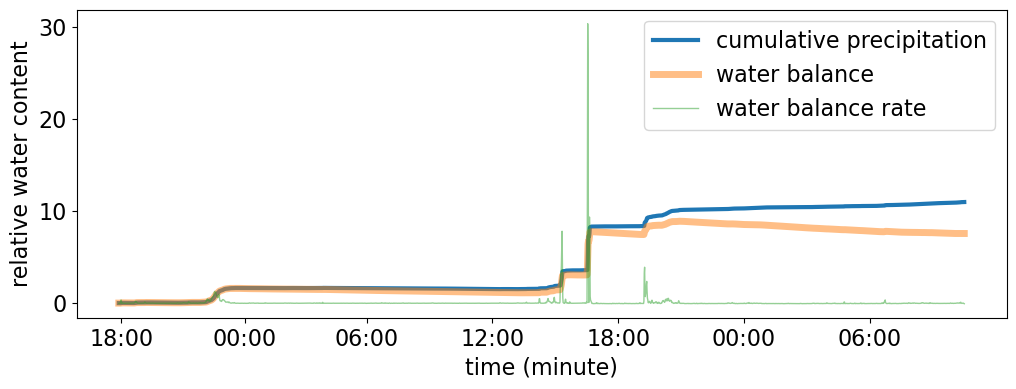

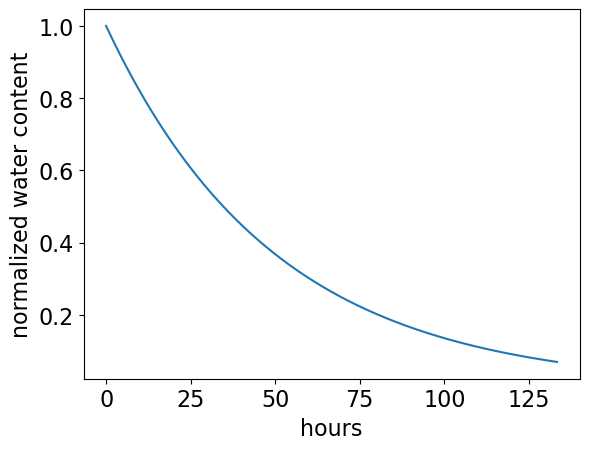

In [111]:
### Incorporate drainage
decay = np.exp(-np.arange(8000)/3000)
res_diff = np.gradient(np.convolve(decay, ave_psd, mode='full')[:2408])

plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(ave_psd), label='cumulative precipitation', lw=3)
plt.plot(np.cumsum(res_diff), label='water balance',lw=5, alpha=0.5)

plt.plot(res_diff*20, label='water balance rate',lw=1, alpha=0.5)
plt.legend()
plt.xlabel('time (minute)')
plt.ylabel('relative water content')
# plt.axvline(x=250,  color='r', linestyle='--', lw=2)
# plt.axvline(x=1260,  color='r', linestyle='--', lw=2)
# plt.axvline(x=1330,  color='r', linestyle='--', lw=2)
# plt.axvline(x=1490,  color='r', linestyle='--', lw=2)
plt.xticks(xax, [t.strftime('%H:%M') for t in tax], fontsize=16)

plt.figure()
plt.plot(np.arange(8000)/60, decay)
plt.ylabel('normalized water content')
plt.xlabel('hours')

# Evapotranspiration

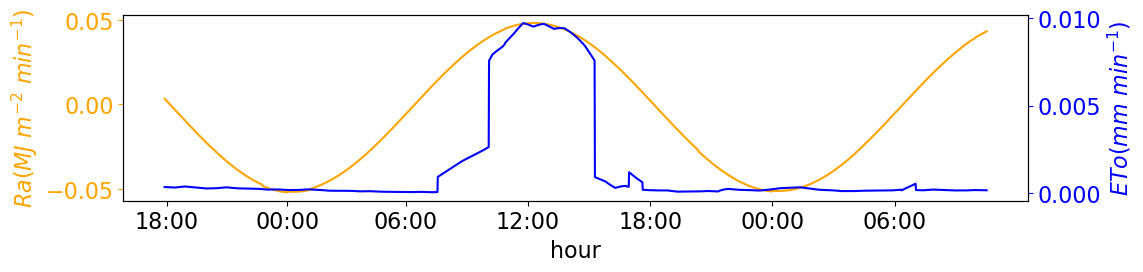

In [112]:
### get the extraterrestrial radiation
lat = 52.78
lon = -2.43
day = 76   ## 17th March
lz = 0  
time = 12.0
duration = 1.0/60  ## 1 minute
rad_a_shortterm(lat, lon, day, lz, time, duration)

rad_every_minute = np.zeros(acqu_time.shape[0])
for imin in range(0, acqu_time.shape[0]):
    day = acqu_time[imin].timetuple().tm_yday
    time = acqu_time[imin].hour + acqu_time[imin].minute/60
    rad_every_minute[imin] = rad_a_shortterm(lat, lon, day, lz, time, 1.0/60)

### get the ETo
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity)
    
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax1.set_xlabel("hour", fontsize=16)
ax1.set_ylabel("$Ra (MJ~m^{-2}~min^{-1})$", fontsize=16, color='orange')
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax1.tick_params(axis='y', colors='orange')

ax2 = ax1.twinx()
ax2.plot(np.arange(acqu_time.shape[0]), eto_every_minute, label='1-minute ETo', color='blue')
ax2.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16, color='blue')
ax2.tick_params(axis='y', colors='blue')

fig.tight_layout()
plt.show()

# Model: Precipitation - Evaporation

--- Contact Analysis at ϕ = 0.5 ---
Total particles: 1000
Fraction of particles with at least one contact: 0.96
Average number of contacts per particle: 3.67
Maximum possible contacts (FCC/HCP): 12
Relative contact efficiency: 30.6%


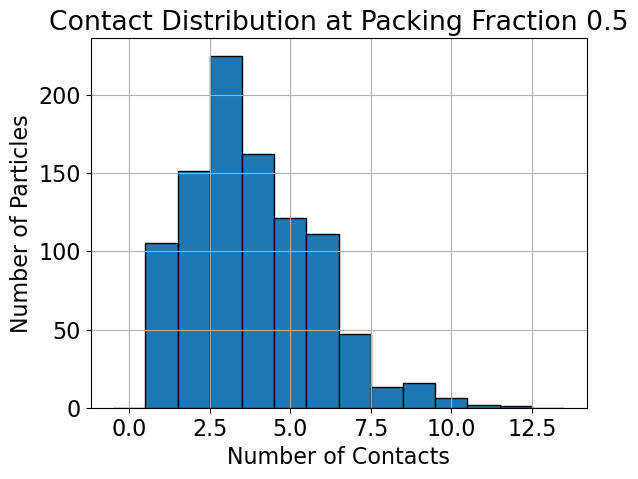

In [113]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Parameters
n_particles = 1000             # number of particles
radius = 1.0                   # radius of each particle
max_contacts = 12             # FCC/HCP ideal contact number
packing_fraction = 0.5      # desired packing fraction

# Geometry calculations
volume_particle = (4/3) * np.pi * radius**3
total_particle_volume = n_particles * volume_particle
box_volume = total_particle_volume / packing_fraction
box_length = box_volume**(1/3)

# Generate random particle positions
positions = np.random.uniform(0, box_length, size=(n_particles, 3))

# Use KD-tree to find neighbors within 2R (touching distance)
tree = cKDTree(positions)
pairs = tree.query_pairs(r=2*radius * 1.01)  # small tolerance

# Count number of contacts per particle
contact_counts = np.zeros(n_particles, dtype=int)
for i, j in pairs:
    contact_counts[i] += 1
    contact_counts[j] += 1

# Compute stats
n_touching = np.sum(contact_counts > 0)
fraction_touching = n_touching / n_particles
avg_contacts = np.mean(contact_counts)

print(f"--- Contact Analysis at ϕ = {packing_fraction} ---")
print(f"Total particles: {n_particles}")
print(f"Fraction of particles with at least one contact: {fraction_touching:.2f}")
print(f"Average number of contacts per particle: {avg_contacts:.2f}")
print(f"Maximum possible contacts (FCC/HCP): {max_contacts}")
print(f"Relative contact efficiency: {avg_contacts / max_contacts * 100:.1f}%")

# Optional: histogram of contact numbers
plt.hist(contact_counts[contact_counts > 0], bins=np.arange(0, 15)-0.5, edgecolor='black')
plt.xlabel("Number of Contacts")
plt.ylabel("Number of Particles")
plt.title("Contact Distribution at Packing Fraction 0.5")
plt.grid(True)
plt.show()

### We tried Sakaki's constitutive laws as below, but chose the other one

In [ ]:
# ### tau values from drainage-wetting experiments by Sakaki et al. (2010)
# tau1 = 1e6 * np.exp(1*np.power(s_history_smooth[0:800],3))  ## wetting
# tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
# tau3 = 1e6 * np.exp(1*np.power(s_history_smooth[1250:1900],3))  ## wetting
# tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
# tau = np.concatenate((tau1, tau2, tau3, tau4))

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_27730/954055405.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


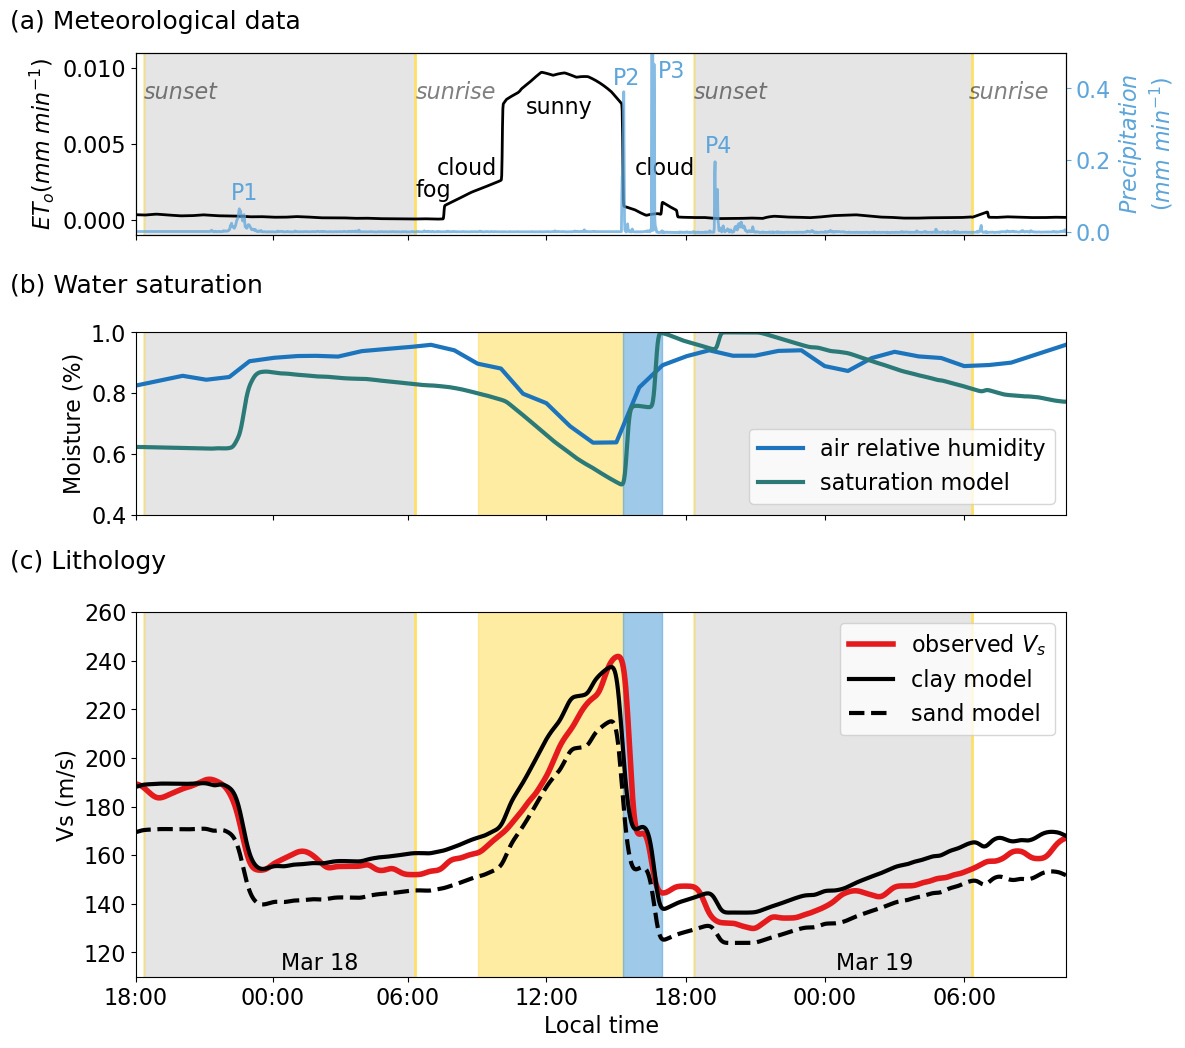

In [325]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = 1400, 0.47

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/3000)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-0.2, interp_temp10, 9, eto_every_minute, 0.9, A_p,A_e,A_d, length=2408, depth=12).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=5, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 10)
s_history_smooth[0:10] = s_history_smooth[10]
s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second

######################### Model lithology
s_wr = 0.25  ## residual saturation
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.4)
new_f_sand = np.minimum((1 - s_history_smooth), 0.4)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind],5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-8*s_history_smooth[dry_ind])  ## drying

### Model the shear wave velocity
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f_sand, s_history_smooth, 0.15, tau, igore_capillary=False).get_vp_vs()
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay = gaussian_filter1d(vs_clay, sigma=10, mode='reflect')
vs_sand = gaussian_filter1d(vs_sand, sigma=10, mode='reflect')

### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[18]+1)*145, sigma=10, mode='reflect')


######################### FIGURE
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.4}, sharex=True)

# Weather data plot
ax3.fill_between([27,   726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.text(27,   0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(726,  0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(1443, 0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(2150, 0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(726, 0.0015, 'fog',     color='k')
ax3.text(780,  0.003, 'cloud',   color='k')
ax3.text(1010,  0.007, 'sunny',  color='k')
ax3.text(1290, 0.003, 'cloud',   color='k')

eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=1, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='reference ET')
ax3.set_ylabel("$ET_o (mm~min^{-1}$)", fontsize=16)
ax3.set_ylim(-0.001, 0.011)
twinx = ax3.twinx()
twinx.plot(np.arange(2408), res_psd, color='#5DA5DA', lw=2, label='rainfall rate', alpha=0.75)
twinx.tick_params(axis='y', colors='#5DA5DA')
twinx.set_ylabel("$Precipitation$\n$(mm~min^{-1})$", fontsize=16, color='#5DA5DA')
twinx.set_ylim(-0.01, 0.5)
twinx.text(250,  0.09, 'P1',  color='#5DA5DA')
twinx.text(1235, 0.41, 'P2',  color='#5DA5DA')
twinx.text(1350, 0.43, 'P3',  color='#5DA5DA')
twinx.text(1470, 0.22, 'P4',  color='#5DA5DA')


# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='air relative humidity', color='#1c75bc', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='saturation model', lw=3, color='#2b7a77')
ax1.set_ylim(0.4, 1)
ax1.set_xlim(10, 2400)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.legend(loc='lower right')


# Lithology plot
ax2.fill_between(np.arange(2408), 110, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [110,110], [260,260], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [110,110], [260,260], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [110,110], [260,260], color='gray', alpha=0.2)
ax2.set_ylim(110, 260)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.text(Ind6hrs[1] + 20, 113, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 113, 'Mar 19', color='k')

ax2.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=4, color='#e41a1c')
ax2.plot(np.arange(2408), vs_clay, label='clay model', color='k', lw=3)
ax2.plot(np.arange(2408), vs_sand, label='sand model', color='k', lw=3, ls='--')
ax2.set_xlabel("Local time", fontsize=16)
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='upper right')



fig.text(0.02, 0.9, '(a) Meteorological data', fontsize=18)
fig.text(0.02, 0.68, '(b) Water saturation', fontsize=18)
fig.text(0.02, 0.45, '(c) Lithology', fontsize=18)

plt.tight_layout()
plt.show()

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_27730/1433593211.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


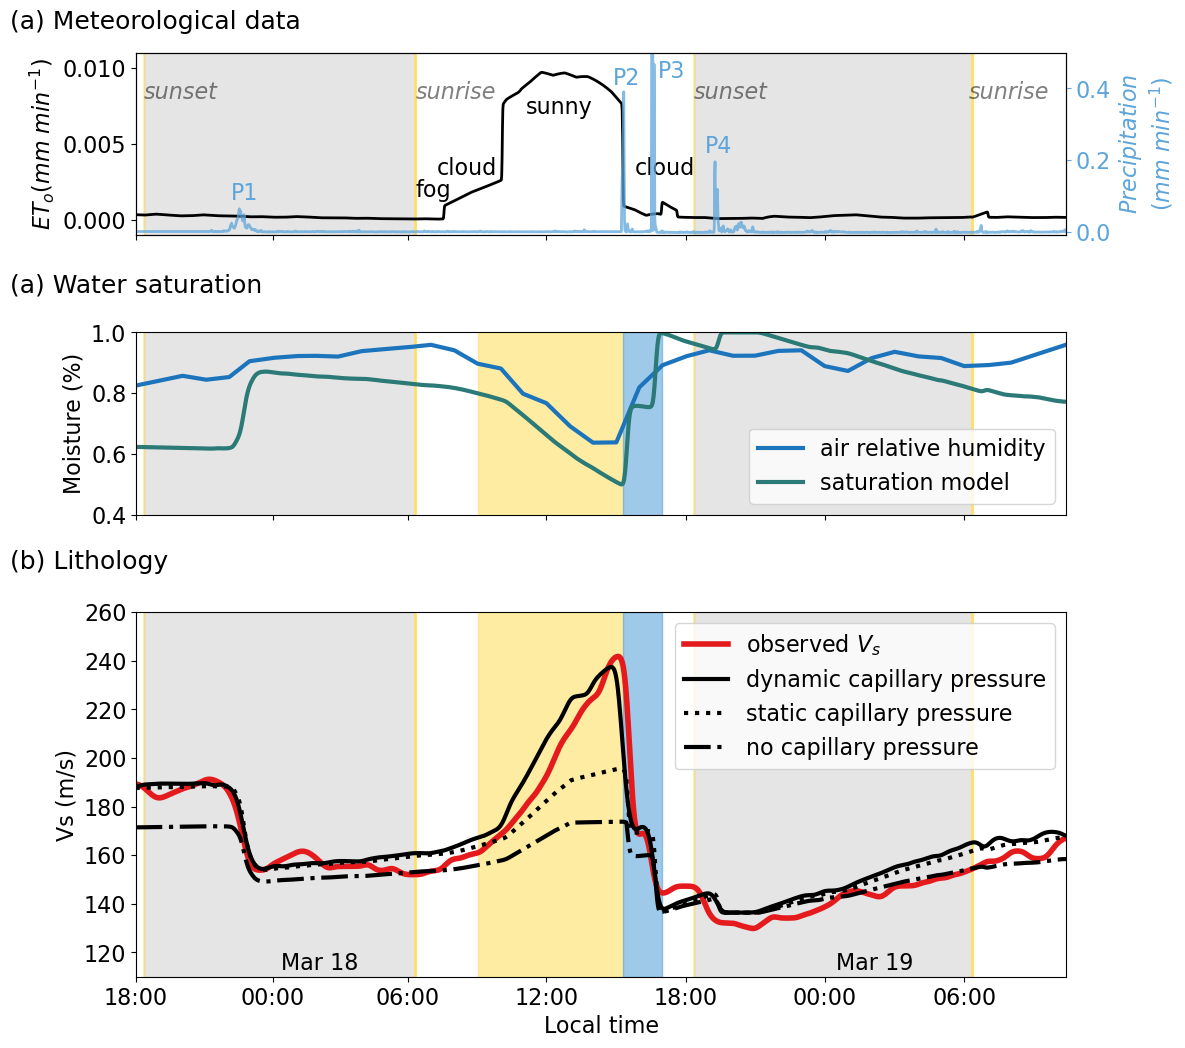

In [324]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = 1400, 0.47

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/3000)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-0.2, interp_temp10, 9, eto_every_minute, 0.9, A_p,A_e,A_d, length=2408, depth=12).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=5, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 10)
s_history_smooth[0:10] = s_history_smooth[10]
s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second

######################### Model lithology
s_wr = 0.25  ## residual saturation
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.4)
new_f_sand = np.minimum((1 - s_history_smooth), 0.4)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind],5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-8*s_history_smooth[dry_ind])  ## drying

### Model the shear wave velocity
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay = gaussian_filter1d(vs_clay, sigma=10, mode='reflect')

vp_clay_static, vs_clay_static,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=False).get_vp_vs()
vp_clay_static = gaussian_filter1d(vp_clay_static, sigma=10, mode='reflect')

vp_clay_nocapi, vs_clay_nocapi,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay_nocapi = gaussian_filter1d(vp_clay_nocapi, sigma=10, mode='reflect')

### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[18]+1)*145, sigma=10, mode='reflect')


######################### FIGURE
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.4}, sharex=True)

# Weather data plot
ax3.fill_between([27,   726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.text(27,   0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(726,  0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(1443, 0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(2150, 0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(726, 0.0015, 'fog',     color='k')
ax3.text(780,  0.003, 'cloud',   color='k')
ax3.text(1010, 0.007, 'sunny',   color='k')
ax3.text(1290, 0.003, 'cloud',   color='k')

eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=1, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='reference ET')
ax3.set_ylabel("$ET_o (mm~min^{-1}$)", fontsize=16)
ax3.set_ylim(-0.001, 0.011)
twinx = ax3.twinx()
twinx.plot(np.arange(2408), res_psd, color='#5DA5DA', lw=2, label='rainfall rate', alpha=0.75)
twinx.tick_params(axis='y', colors='#5DA5DA')
twinx.set_ylabel("$Precipitation$\n$(mm~min^{-1})$", fontsize=16, color='#5DA5DA')
twinx.set_ylim(-0.01, 0.5)
twinx.text(250,  0.09, 'P1',  color='#5DA5DA')
twinx.text(1235, 0.41, 'P2',  color='#5DA5DA')
twinx.text(1350, 0.43, 'P3',  color='#5DA5DA')
twinx.text(1470, 0.22, 'P4',  color='#5DA5DA')


# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='air relative humidity', color='#1c75bc', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='saturation model', lw=3, color='#2b7a77')
ax1.set_ylim(0.4, 1)
ax1.set_xlim(10, 2400)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.legend(loc='lower right')


# Lithology plot
ax2.fill_between(np.arange(2408), 110, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [110,110], [260,260], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [110,110], [260,260], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [110,110], [260,260], color='gray', alpha=0.2)
ax2.set_ylim(110, 260)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.text(Ind6hrs[1] + 20, 113, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 113, 'Mar 19', color='k')

ax2.plot(np.arange(2408), v_obs,          label='observed $V_s$', color='#e41a1c', lw=4,)
ax2.plot(np.arange(2408), vs_clay,        label='dynamic capillary pressure', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay_static, label='static capillary pressure', color='k', lw=3, ls=':')
ax2.plot(np.arange(2408), vs_clay_nocapi, label='no capillary pressure', color='k', lw=3, ls='-.')
ax2.set_xlabel("Local time", fontsize=16)
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='upper right')



fig.text(0.02, 0.9, '(a) Meteorological data', fontsize=18)
fig.text(0.02, 0.68, '(a) Water saturation', fontsize=18)
fig.text(0.02, 0.45, '(b) Lithology', fontsize=18)

plt.tight_layout()
plt.show()

(1200.0, 1299.0)

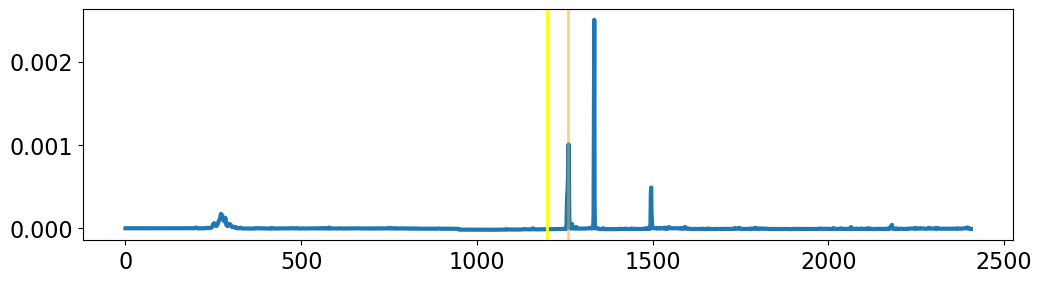

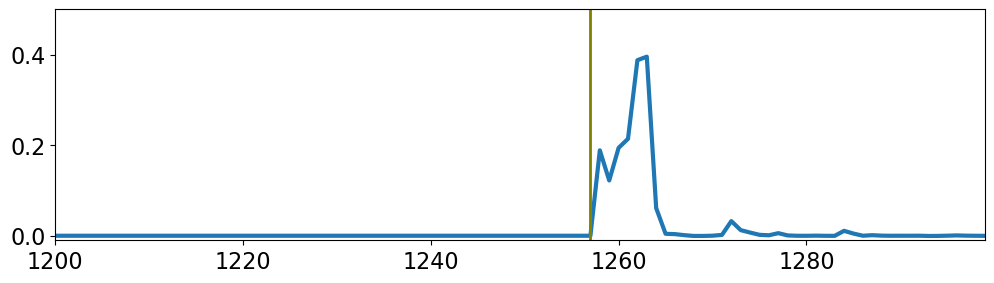

In [191]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(2407), s_rate, lw=3)
plt.axvline(x=1260, color='orange', linestyle='-', lw=2, alpha=0.5)
plt.axvline(x=1200, color='yellow', linestyle='-', lw=2, alpha=1)

ave_psd_inspect = ave_psd
ave_psd_inspect[1190:1258] = 0 
ave_psd_inspect[:200] = 0 
plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), ave_psd, lw=3)
plt.ylim(-0.01, 0.5)
# plt.xlim(1150, 1300)
plt.axvline(x=1190, color='orange', linestyle='-', lw=2, alpha=0.5)
plt.axvline(x=1257, color='yellow', linestyle='-', lw=2, alpha=1)

plt.axvline(x=249, color='k', linestyle='-', lw=2, alpha=0.5)
plt.axvline(x=1257, color='k', linestyle='-', lw=2, alpha=0.5)
plt.axvline(x=1334, color='k', linestyle='-', lw=2, alpha=0.5)
plt.axvline(x=1495, color='k', linestyle='-', lw=2, alpha=0.5)
plt.xlim(1200, 1299)

In [159]:
acqu_time[249], acqu_time[1334], acqu_time[1495], acqu_time[1257]

(2023-03-17T22:02:00.000000Z,
 2023-03-18T16:32:00.000000Z,
 2023-03-18T19:13:00.000000Z,
 2023-03-18T15:14:00.000000Z)

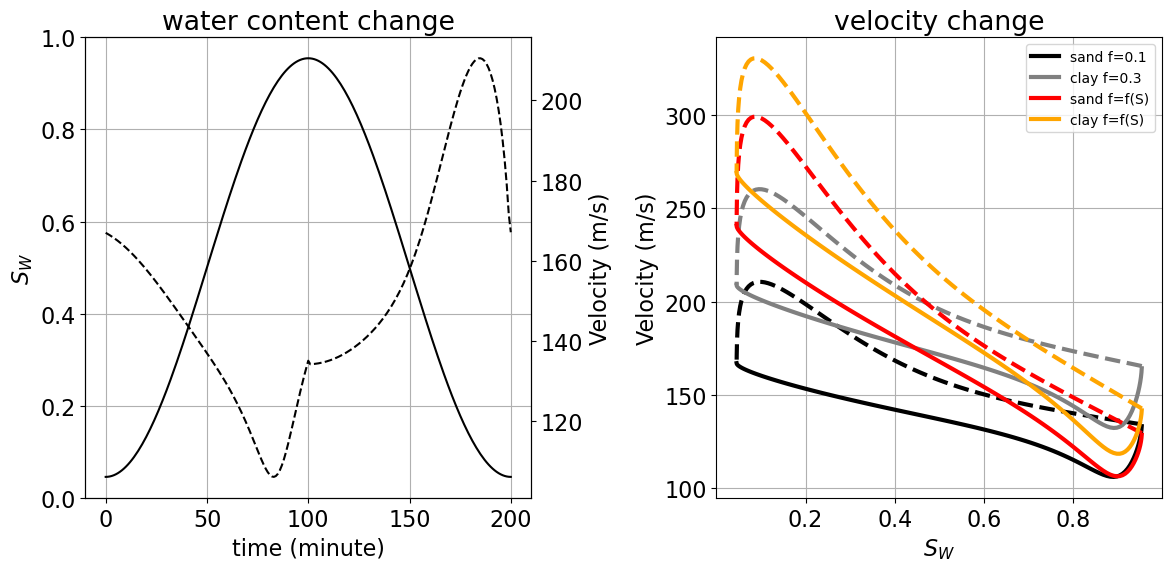

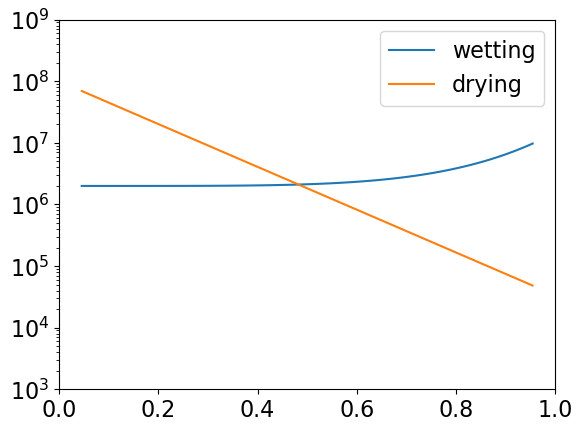

In [ ]:
def symmetric_function(length):
    """
    Generate a cosine-shaped symmetric function array of given length.
    The function is symmetric around its center.

    Parameters:
    length (int): Length of the array.

    Returns:
    numpy.ndarray: Symmetric array.
    """
    if length % 2 == 0:
        raise ValueError("Length must be odd to ensure symmetry.")
    center = length // 2
    x = np.linspace(-np.pi, np.pi, length)
    return np.cos(x)



# Plot the symmetric function and velocity as subfigures
length = 201  # Example length
half_length = length // 2
symmetric_array = symmetric_function(length) / 2.2 + 0.5

# Prepare data for velocity plot
# tau1 = 2e6 * np.exp(2*np.power(symmetric_array[0:half_length+1], 3))  # wetting
# tau2 = 1e7 * (1 - symmetric_array[half_length+1:])  # drying

tau1 = 2e6 * np.exp(2*np.power(symmetric_array[0:half_length+1],5))  ## wetting
tau2 = 1e8 * np.exp(0-8* symmetric_array[half_length+1:])  ## drying

tau = np.concatenate((tau1, tau2))

scale_factor = (symmetric_array+1)/2 * 3 - 0.6
new_f = 1-symmetric_array

bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, 0.1, symmetric_array[:], 0.15, tau).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, 0.3, symmetric_array[:], 0.25, tau).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, new_f, symmetric_array[:], 0.15, tau).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, new_f, symmetric_array[:], 0.25, tau).get_vp_vs()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

# Subfigure 1: Symmetric Function
ax1.plot(symmetric_array, label="water content", color="k")
twinx = ax1.twinx()
twinx.plot(vs_sand, label="velocity", color="k", linestyle="--")
twinx.set_ylabel("Velocity (m/s)", color="k")
twinx.tick_params(axis='y', labelcolor="k")
ax1.set_title("water content change")
ax1.set_xlabel("time (minute)")
ax1.set_ylabel("$S_W$")
# ax1.legend()
ax1.grid(True)



# Subfigure 2: Velocity
ax2.plot(symmetric_array[:half_length], vs_sand[:half_length], label="sand f=0.1", color="k", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_sand[half_length+1:], color="k", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_clay[:half_length], label="clay f=0.3", color="gray", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_clay[half_length+1:], color="gray", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_sand1[:half_length], label="sand f=f(S)", color="red", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_sand1[half_length+1:],  color="red", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_clay1[:half_length], label="clay f=f(S)", color="orange", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_clay1[half_length+1:],  color="orange", lw=3, ls="--")
ax2.set_title("velocity change")
ax2.set_xlabel("$S_W$")
ax2.set_ylabel("Velocity (m/s)")
ax2.legend(fontsize=10)
ax2.grid(True)

plt.show()

plt.plot(symmetric_array[0:half_length+1], tau1, label="wetting")
plt.plot(symmetric_array[half_length+1:], tau2, label="drying")
plt.yscale('log')
plt.ylim(1e3, 1e9)
plt.legend()



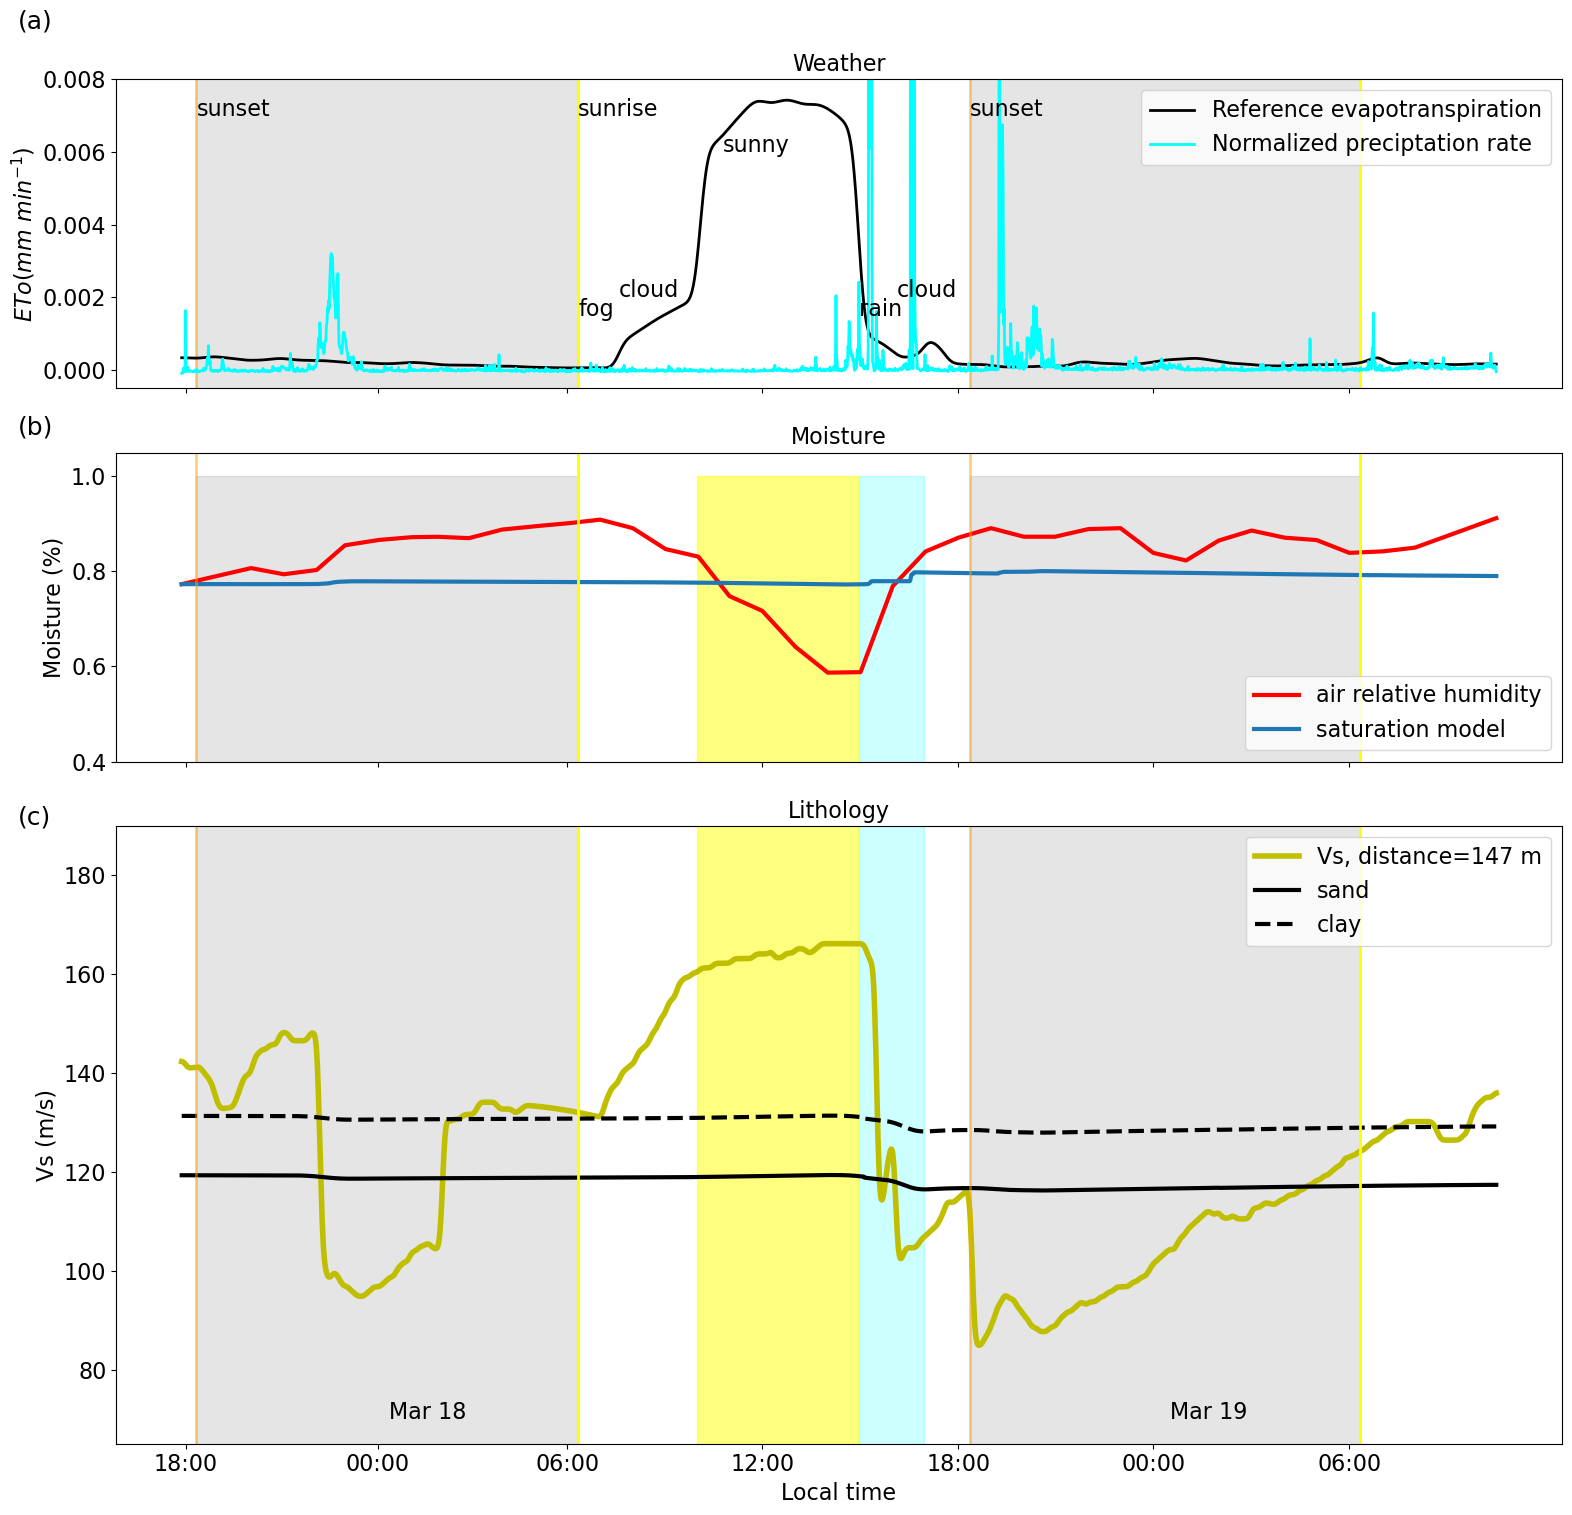

In [ ]:
## Model the water balance
A_e = 0.35
# A_d = 0.1
A_d = 0
A_p = 0.20
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
# eto_every_minute=eto_shortterm(rad, air_temp_interpolated, wind_speed_interpolated*0.75, humidity_interpolated)
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

decay = np.exp(-np.arange(8000)*5/8000)
res_psd = np.gradient(np.convolve(decay, ave_psd, mode='full')[:2408])
s_history = hydro0(res_psd*2, 0.5, interp_humidity[0]/100-0.05, interp_temp10, 9, eto_every_minute, 0.7, A_p,A_e,A_d).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=25, mode='reflect')

## Model the lithology
## Input parameters
s_wr = 0.3  ## residual saturation
s=interp_humidity/100
# scale_factor = moisture/100 * 2.5 - 0.6
scale_factor = (s_history_smooth+1)/2 * 3 - 0.6
new_f = 0.9-scale_factor/2
   
tau1 = 5e6 * np.exp(np.power(s_history_smooth[0:800],3))  ## wetting
tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
tau3 = 5e6 * np.exp(np.power(s_history_smooth[1250:1900],3))  ## wetting
tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
tau = np.concatenate((tau1, tau2, tau3, tau4))

s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second
p_diff = 0-np.concatenate((s_rate, [0])) * tau

bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()


### Plot the water balance
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(16, 15), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 2]})

# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.plot(np.arange(2408), s-0.05, label='air relative humidity', color='r', lw=3)
ax1.plot(np.arange(2408), s_history, label='saturation model', lw=3)
# ax1.plot(np.arange(2408), s_history_smooth, label='smoothed model', linestyle='--', lw=3)
ax1.set_ylim(0.4, 1.05)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels([])
ax1.set_title("Moisture", fontsize=16)
ax1.legend(loc='lower right')
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)

# Lithology plot
ax2.fill_between(np.arange(2408), 60, 190, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax2.fill_between([1240,1360], [60,60], [190,190], color='cyan', alpha=0.2)
ax2.fill_between([27,726], [60,60], [190,190], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [60,60], [190,190], color='gray', alpha=0.2)
# ax2.plot(np.arange(2408), dvv*135, label='org_Vs', lw=2, color='b')
# ax2.plot(np.arange(2408), (dvv_all[18]+1)*90, label='Vs, distance=57 m', lw=4, color='r')
ax2.plot(np.arange(2408), (dvv_all[44]+1)*108, label='Vs, distance=147 m', lw=4, color='y')
# ax2.plot(np.arange(2408), (dvv_all[33]+1)*90, label='Vs, distance=105 m', lw=4, color='g')
ax2.plot(np.arange(2408), vs_sand, label='sand', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay, label='clay', color='k', lw=3, ls='--')
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_title("Lithology", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='upper right')
ax2.set_ylim(65, 190)
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(Ind6hrs[1] + 20, 70, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 70, 'Mar 19', color='k')
ax2.set_xlabel("Local time", fontsize=16)

# Weather data plot
ax3.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.set_ylim(-0.0005, 0.008)
ax3.text(726, 0.0015, 'fog', color='k')
ax3.text(800, 0.002, 'cloud', color='k')
ax3.text(990, 0.006, 'sunny', color='k')
ax3.text(1240, 0.0015, 'rain', color='k')
ax3.text(1310, 0.002, 'cloud', color='k')
ax3.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.text(27, 0.007, 'sunset', color='k')
ax3.text(726, 0.007, 'sunrise', color='k')
ax3.text(1443, 0.007, 'sunset', color='k')
# ax3.text(2158, 0.007, 'sunrise', color='k')
eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=10, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='Reference evapotranspiration')
# ax3.plot(np.arange(2408), etc_smooth, label='inverted ET rate', color='gray', lw=2, linestyle='--')
ax3.plot(np.arange(2408), ave_psd/20, color='cyan', lw=2, label='Normalized preciptation rate')
# ax3.plot(np.arange(2408), res_diff/20, label='precipitation - drainage',lw=2, alpha=0.5,  color='cyan')
ax3.set_xticks(xax)
ax3.set_xticklabels([])
ax3.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16)
ax3.set_title("Weather", fontsize=16)
ax3.legend(loc='upper right')

# twinx = ax3.twinx()
# # twinx.plot(np.arange(2408), interp_temp10, color='gray', lw=2, label='temperature')
# twinx.set_ylabel("Soil Temperature", fontsize=16, color='gray')
# twinx.tick_params(axis='y', colors='gray')

fig.text(0.02, 1.0, '(a)', fontsize=18)
fig.text(0.02, 0.73, '(b)', fontsize=18)
fig.text(0.02, 0.47, '(c)', fontsize=18)

plt.tight_layout()
plt.show()

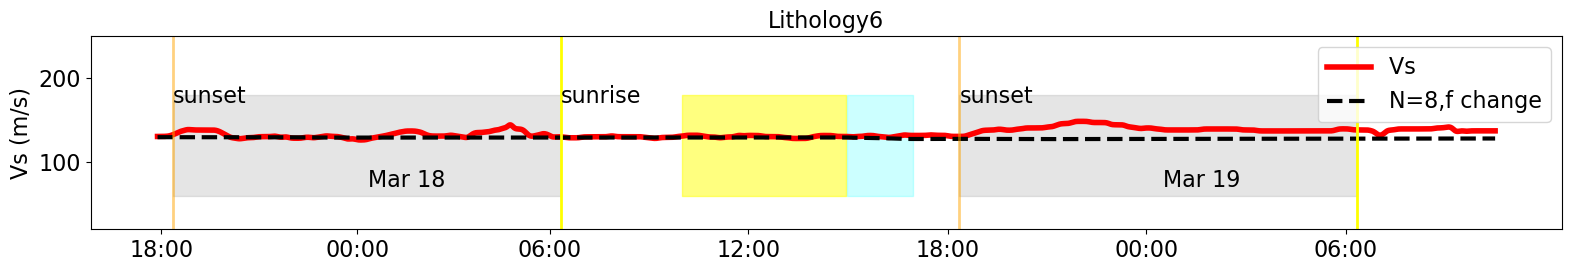

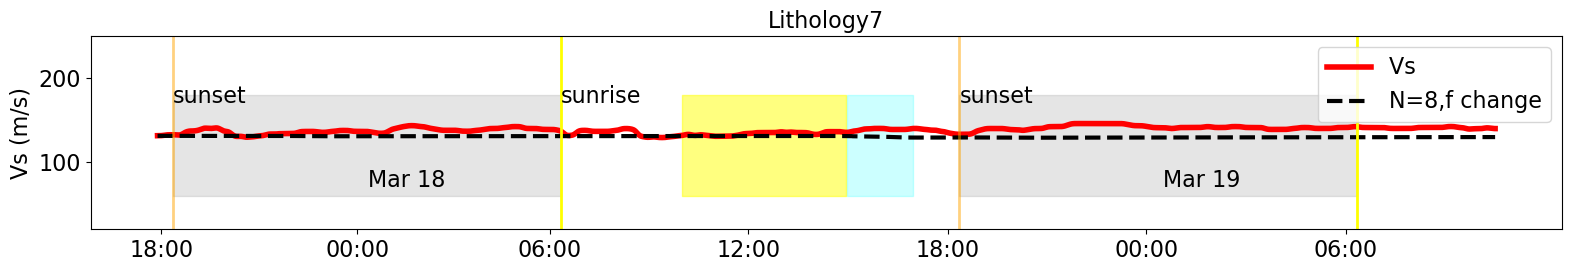

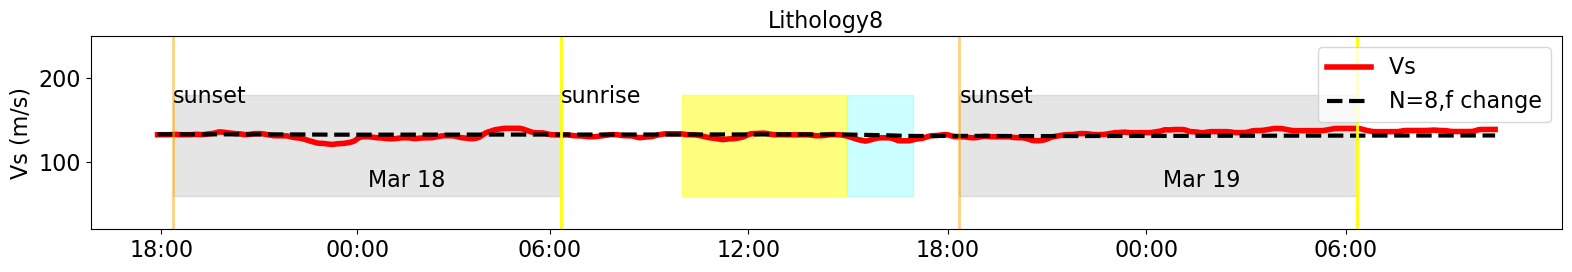

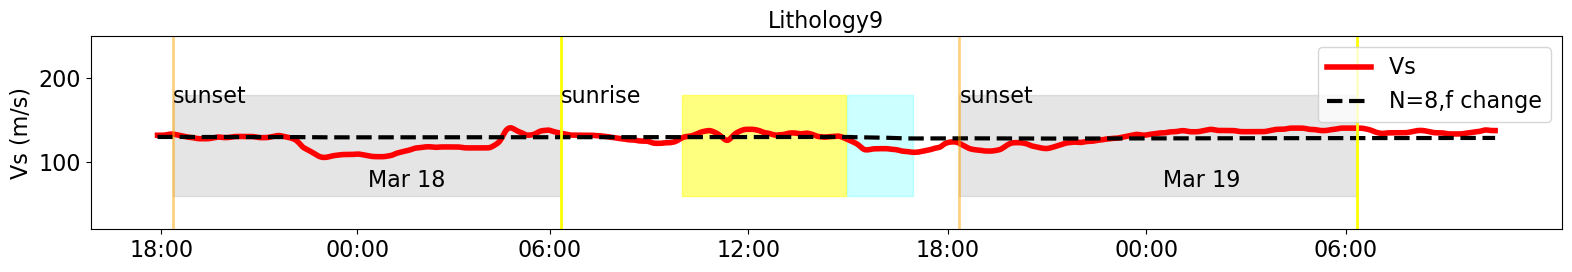

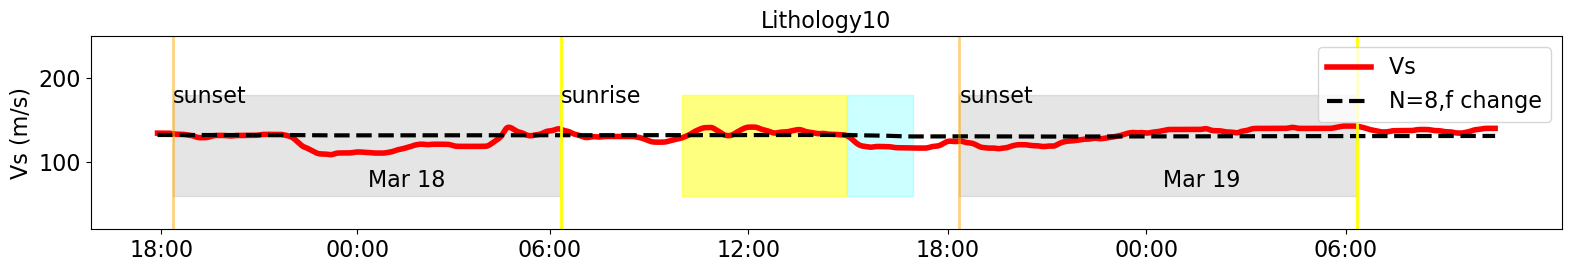

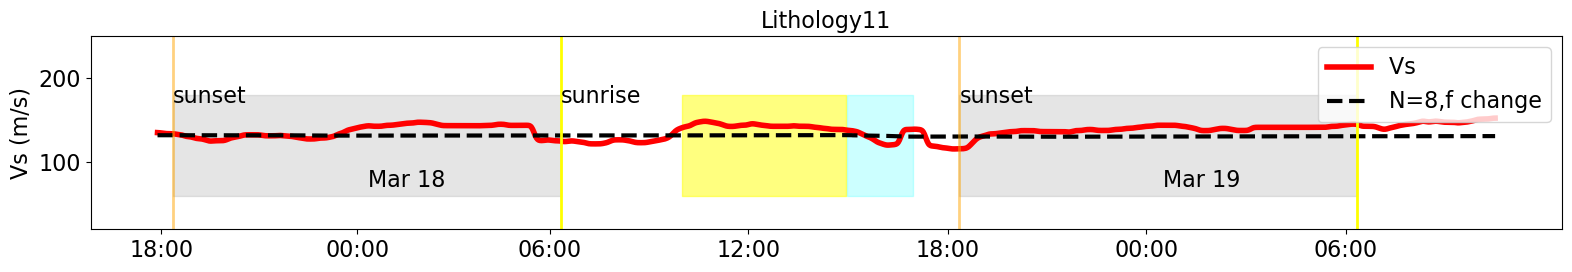

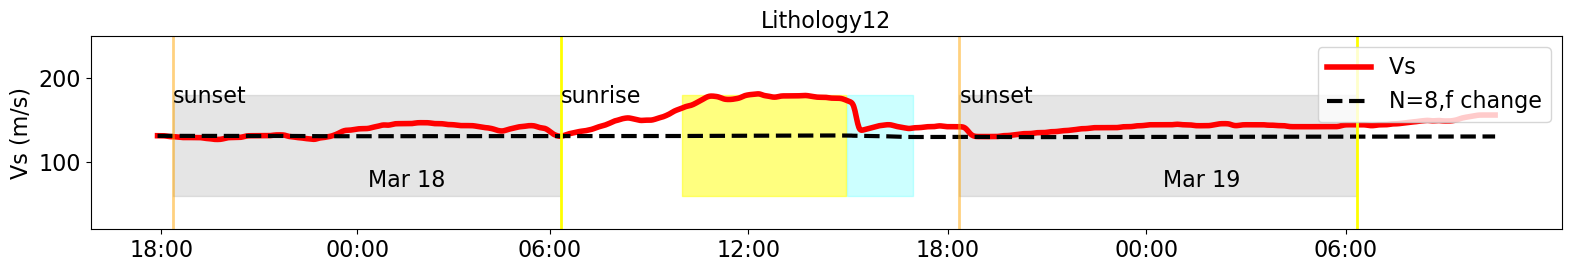

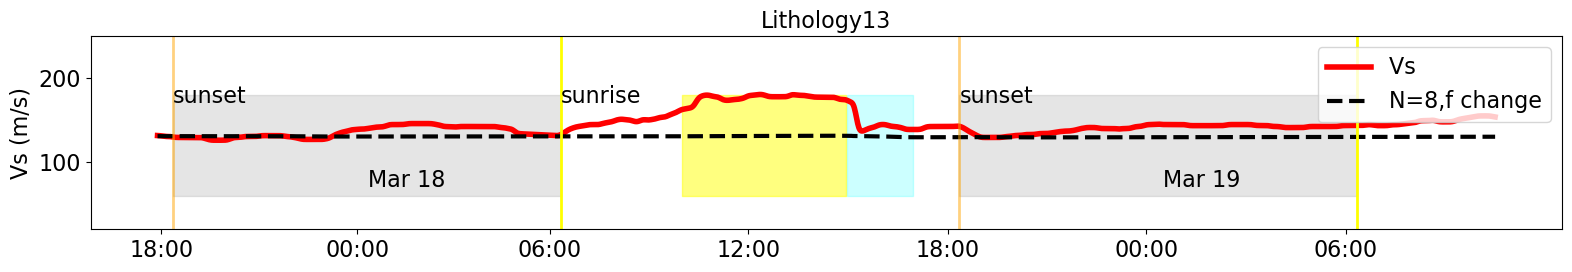

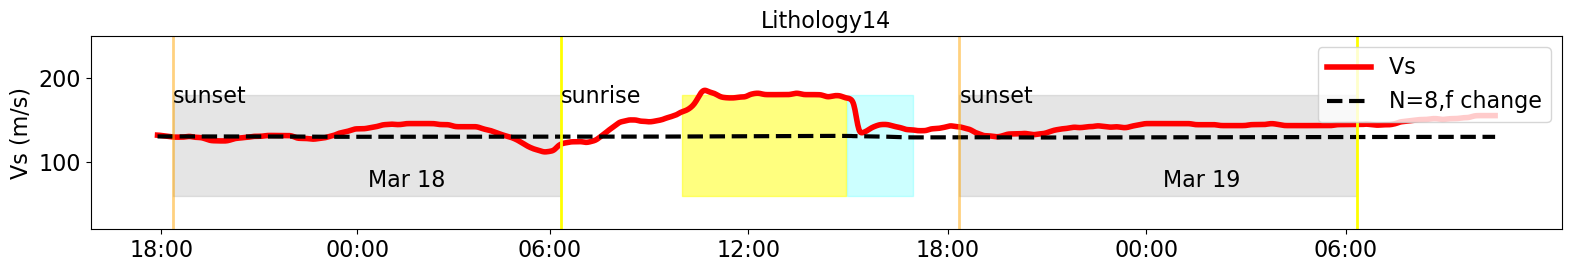

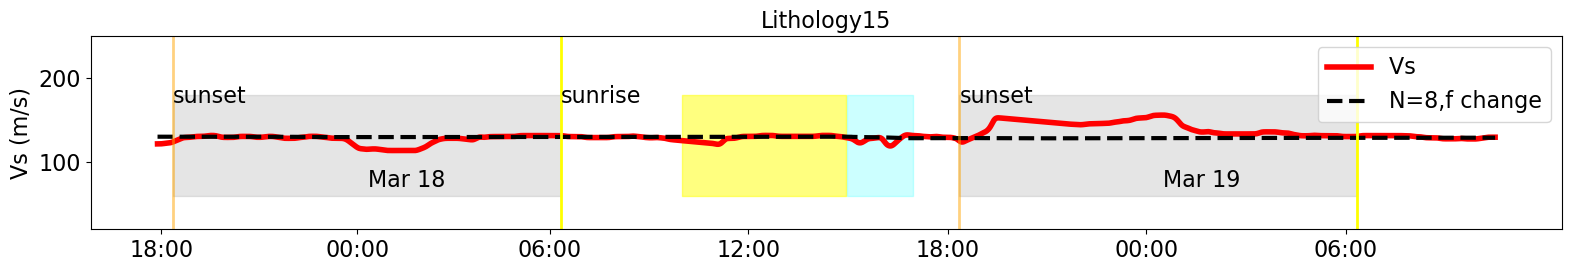

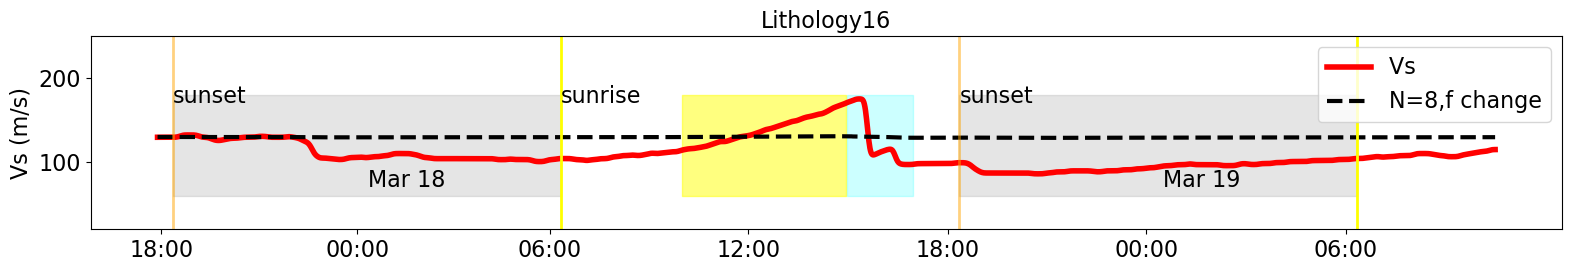

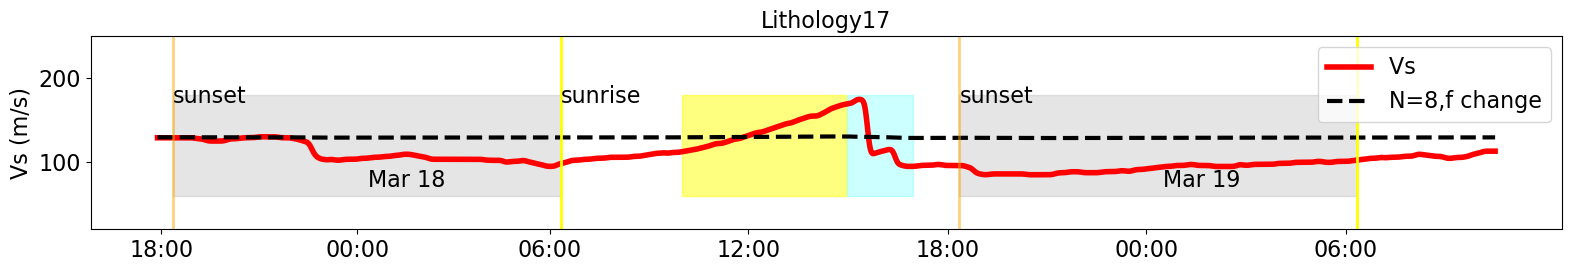

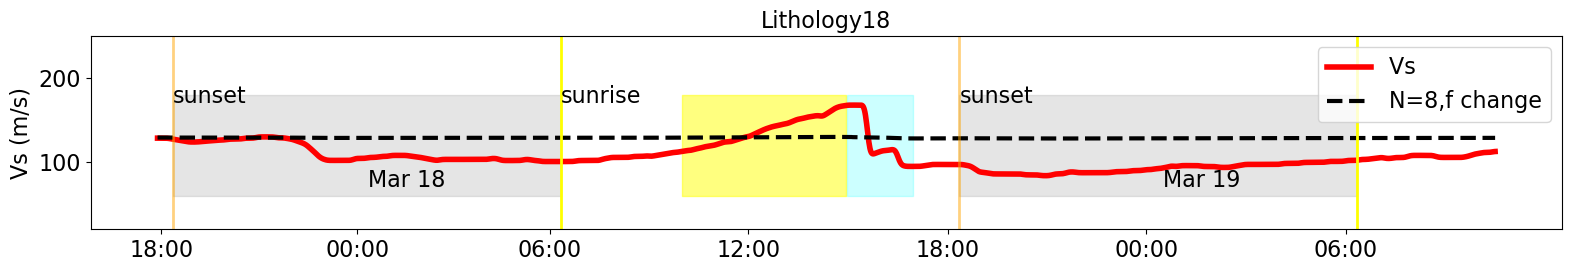

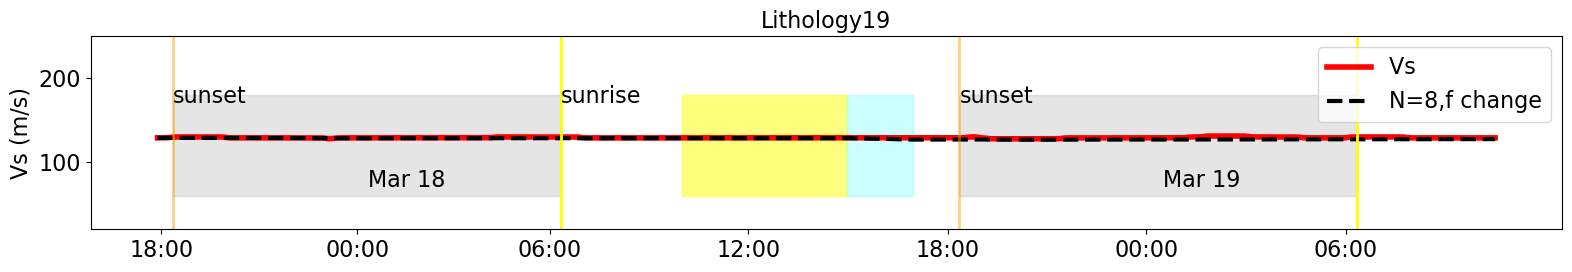

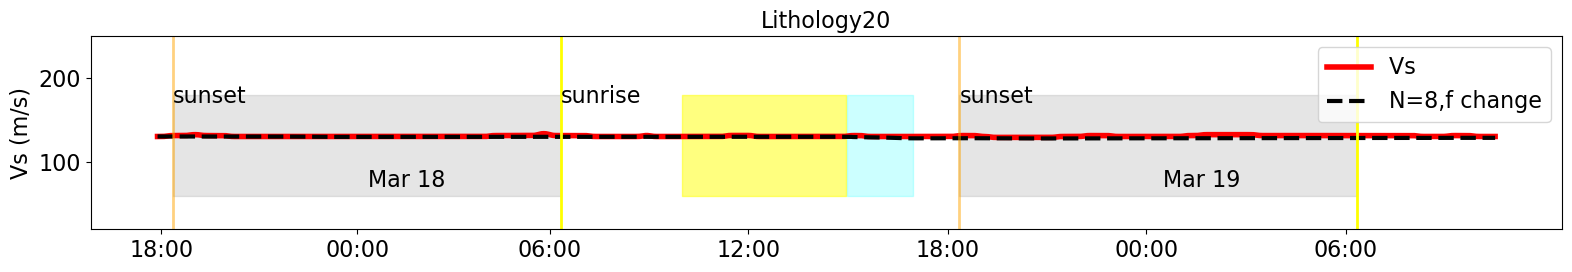

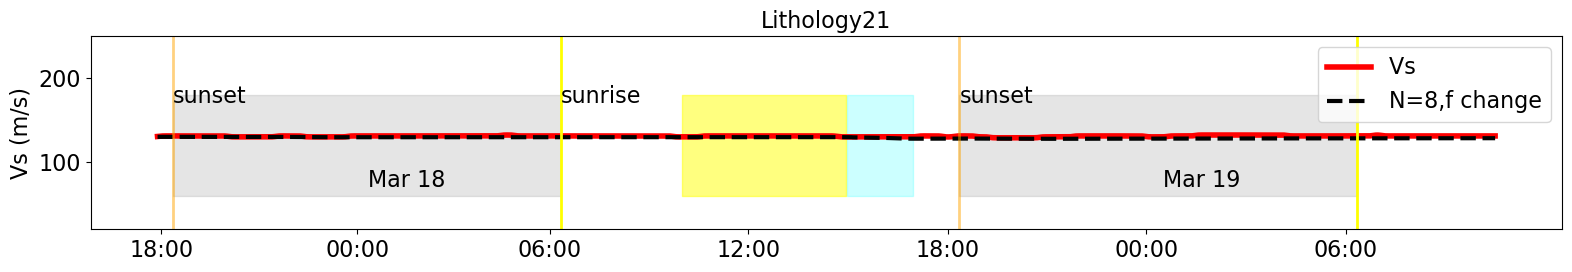

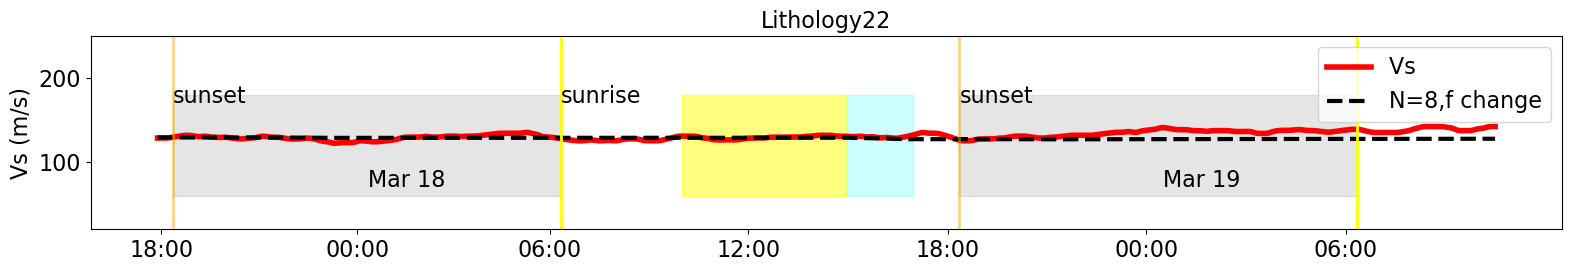

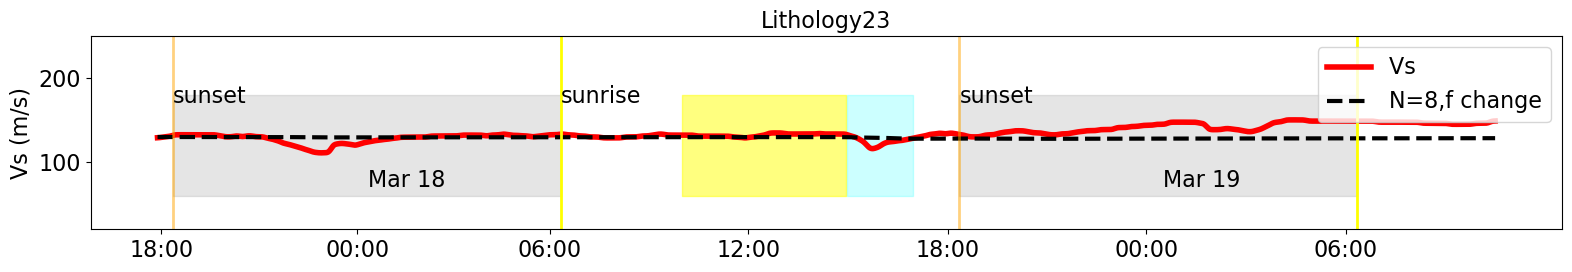

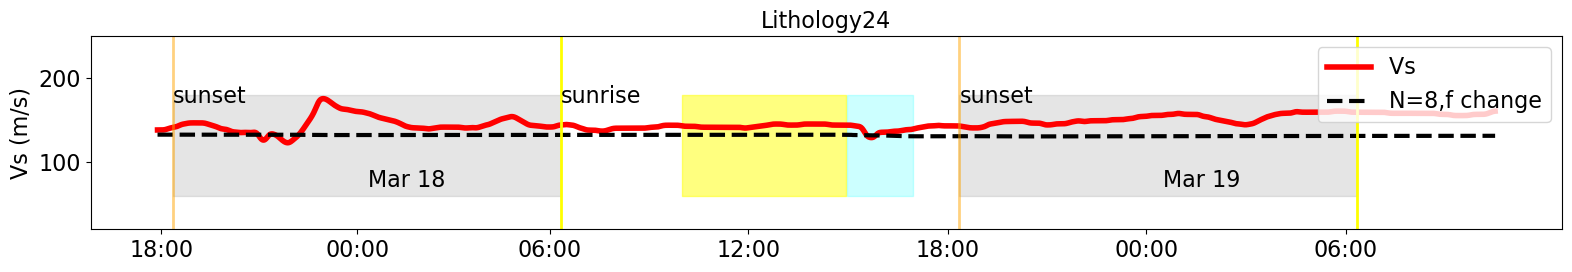

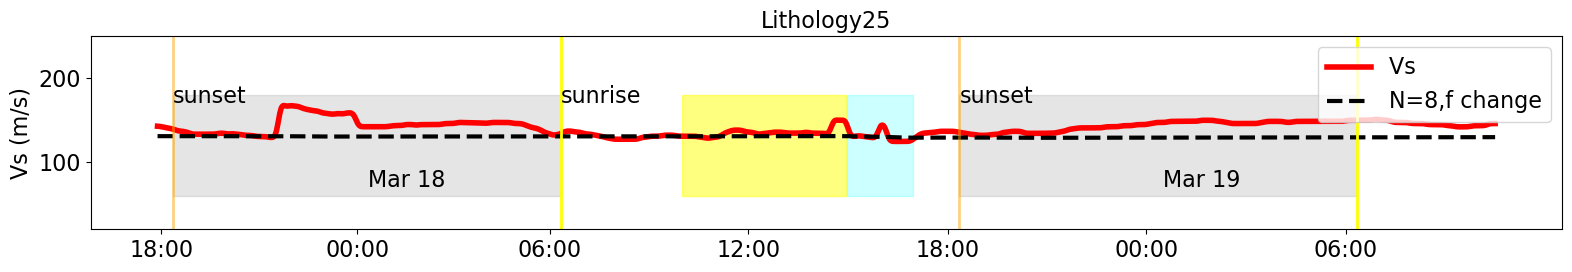

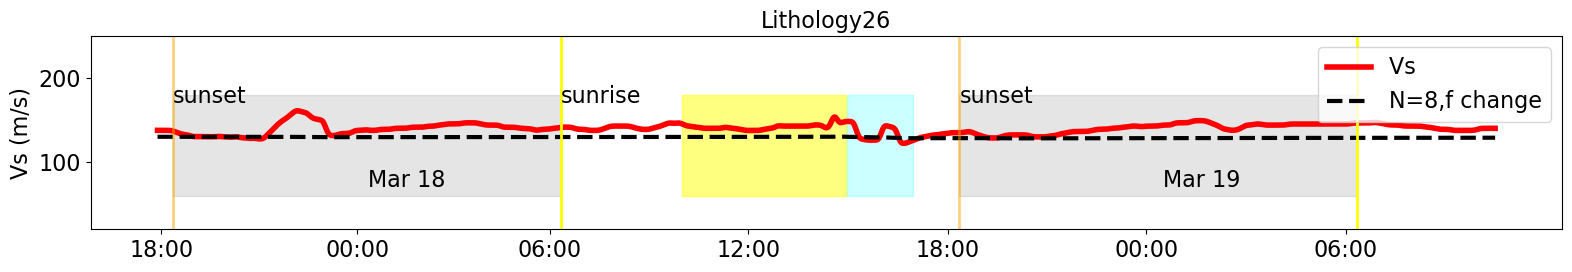

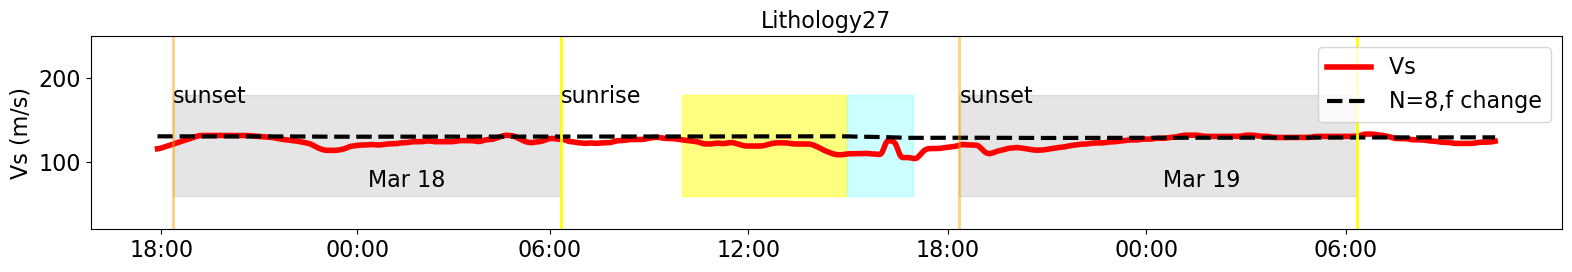

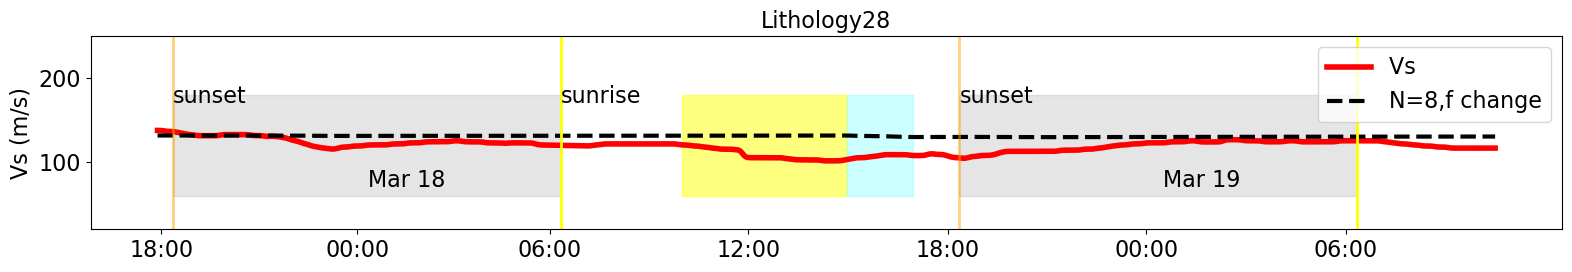

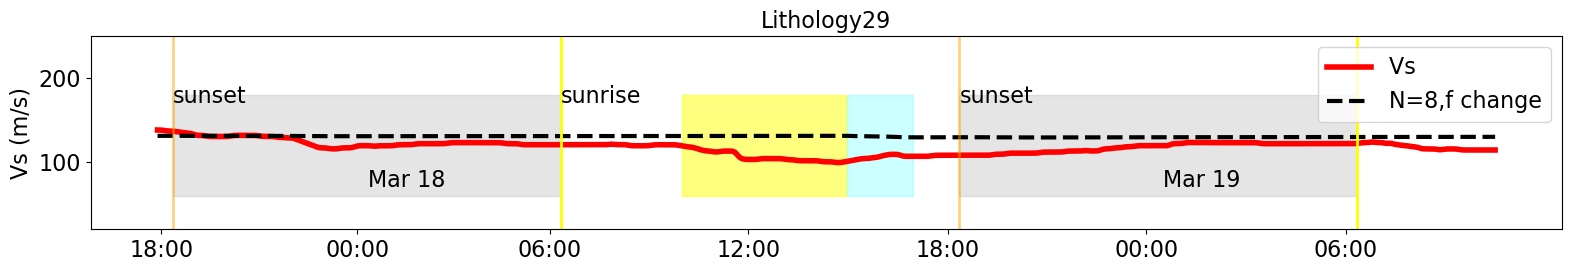

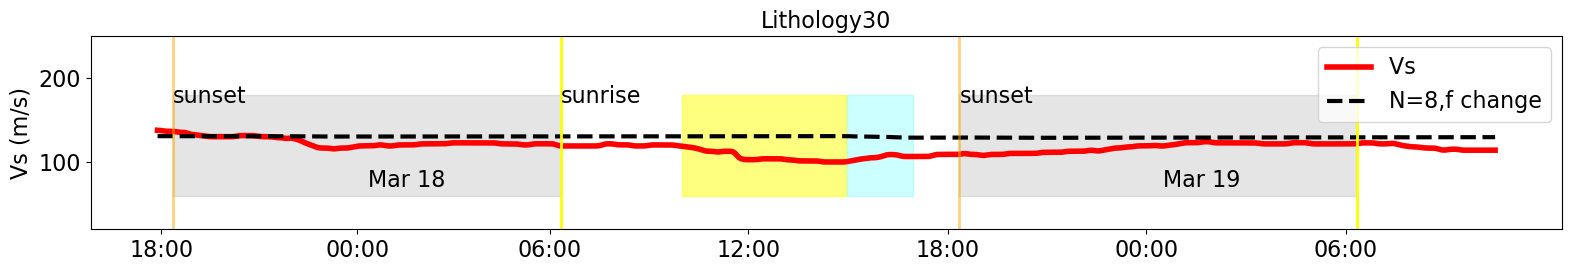

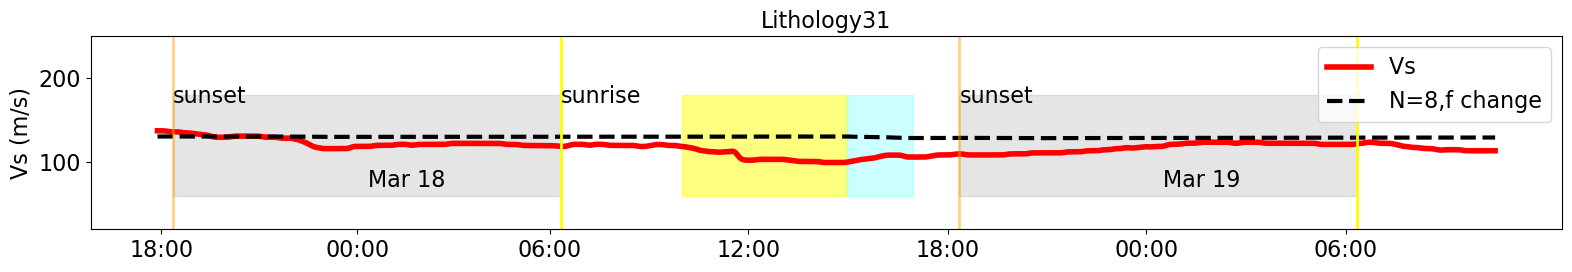

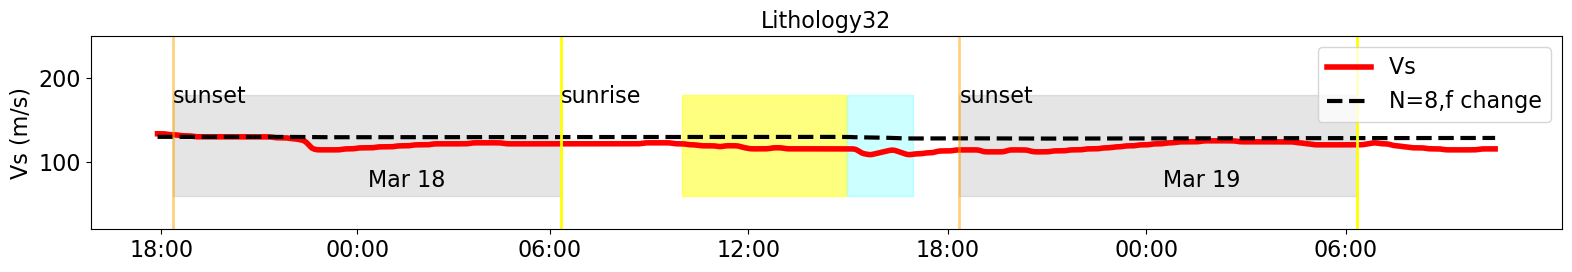

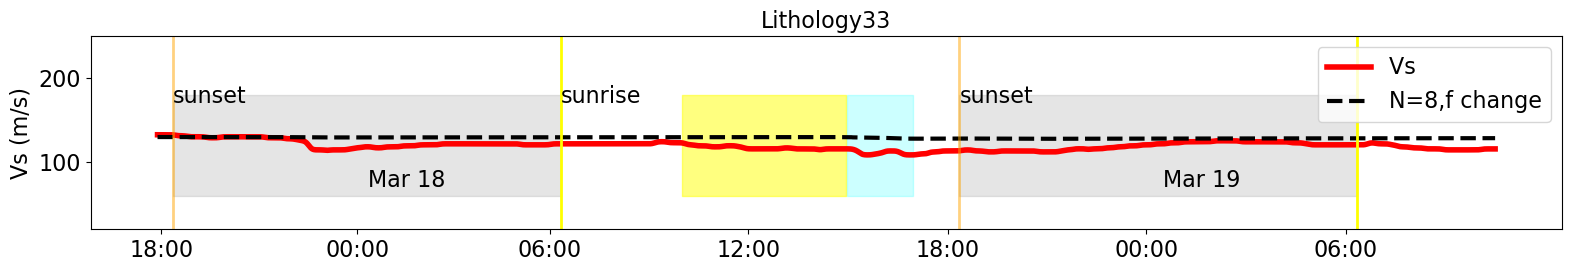

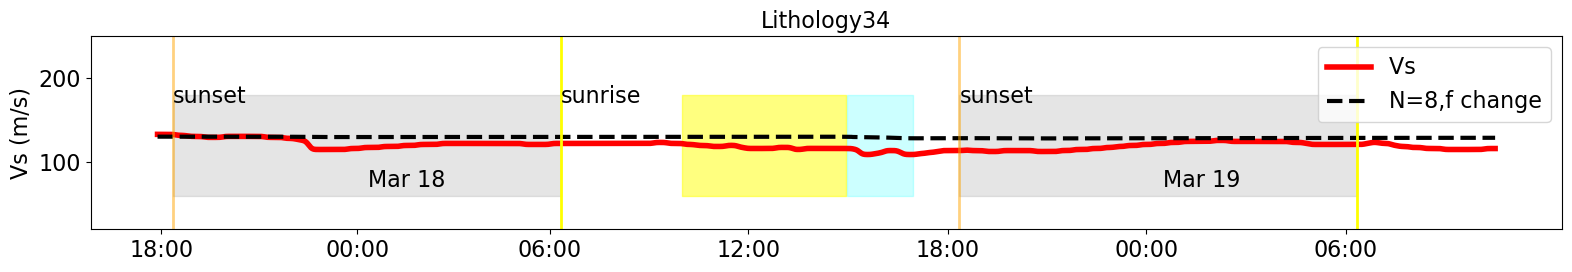

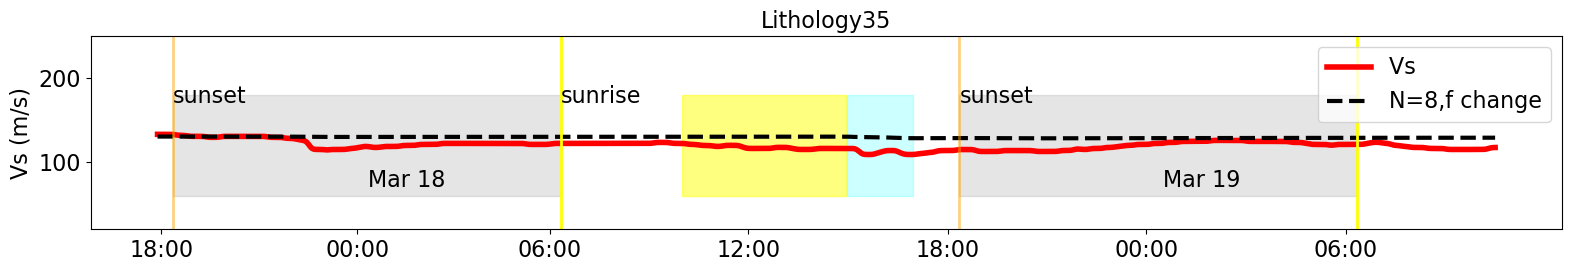

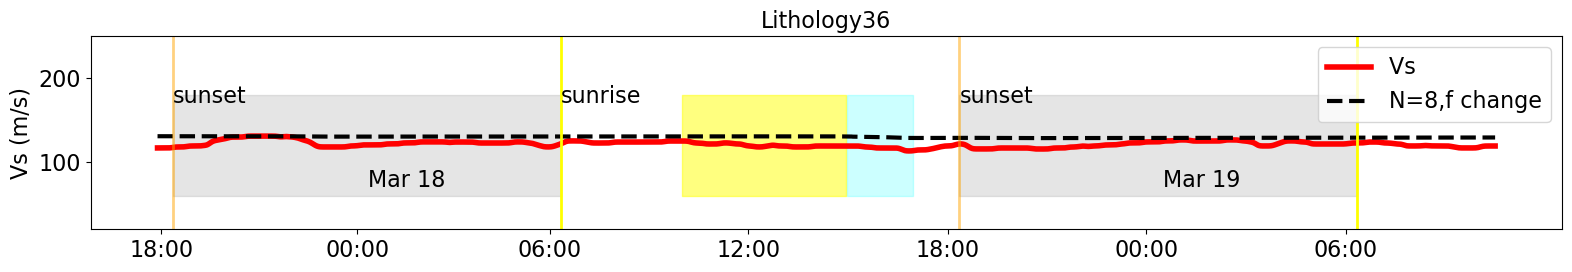

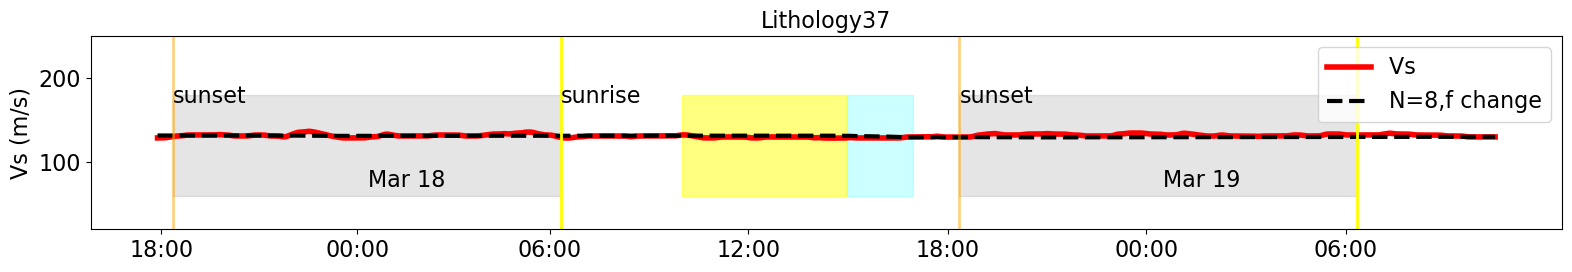

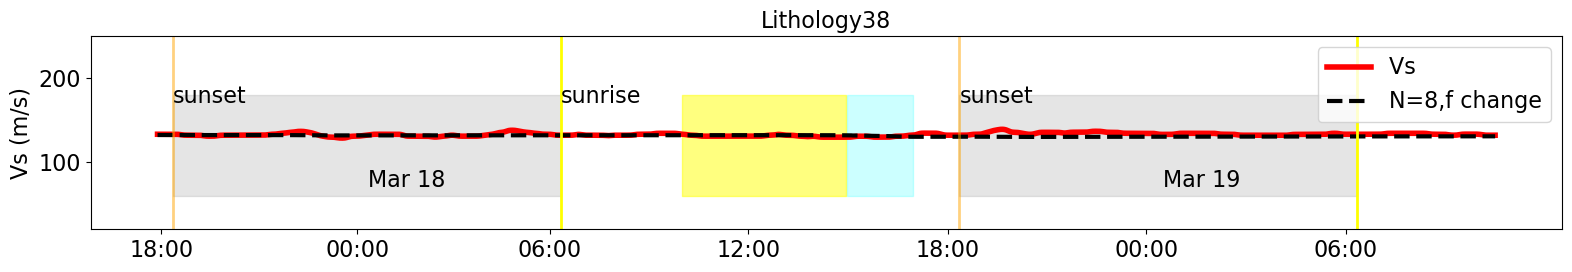

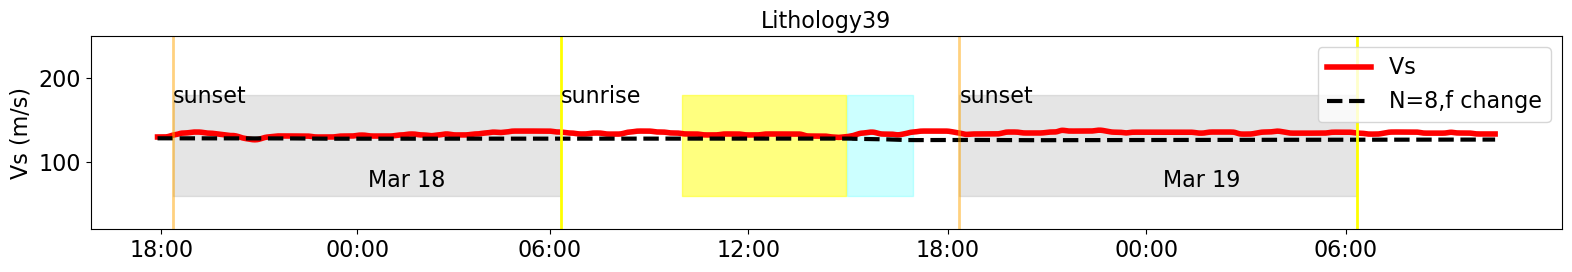

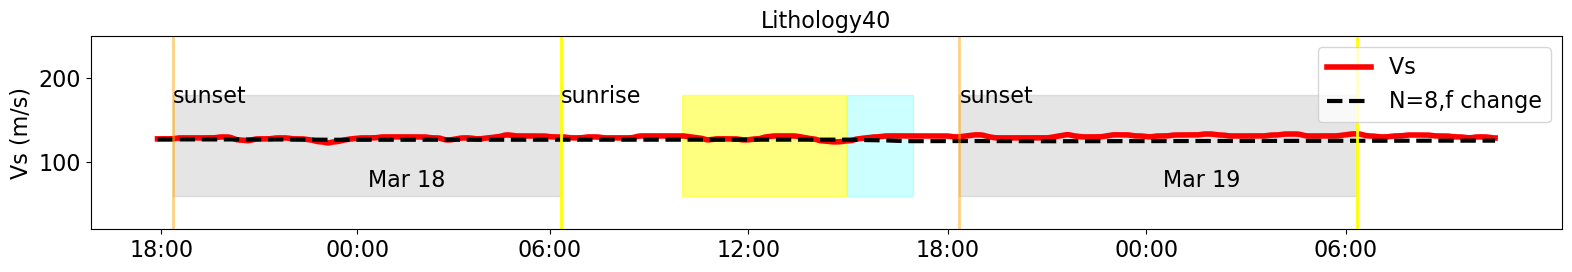

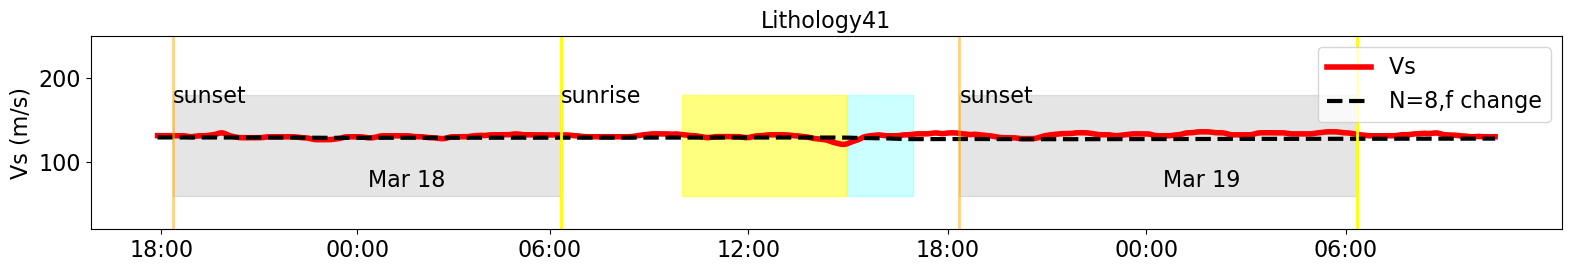

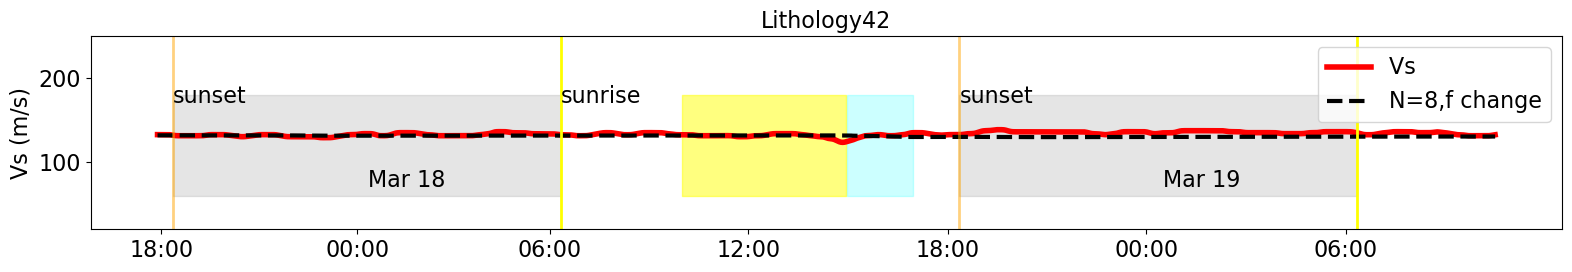

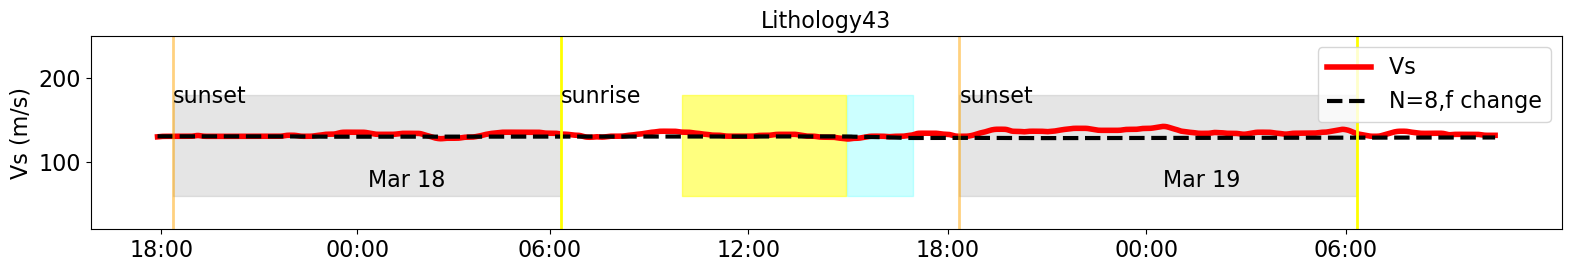

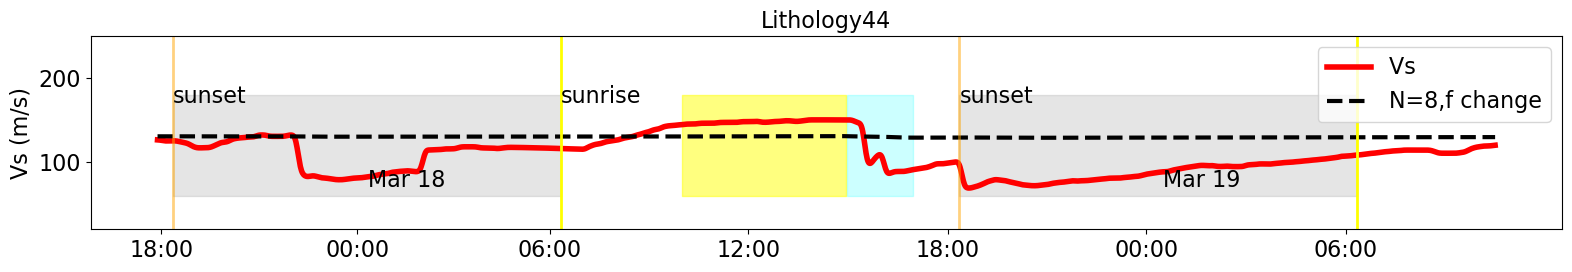

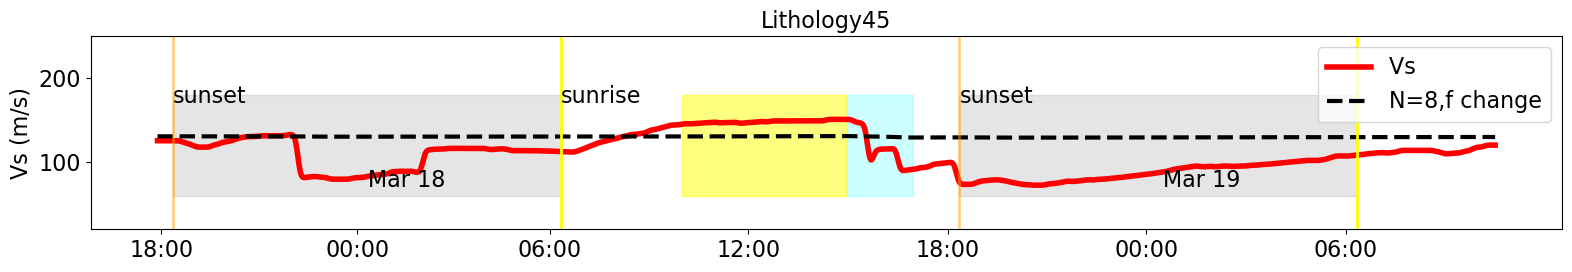

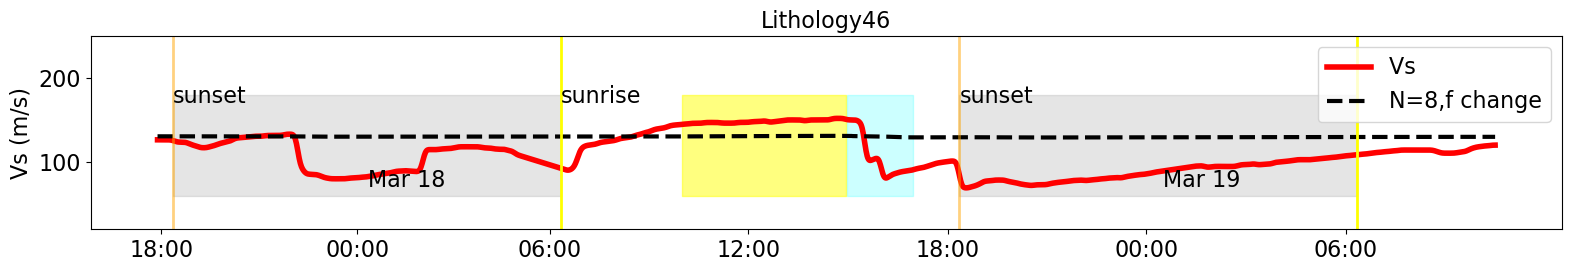

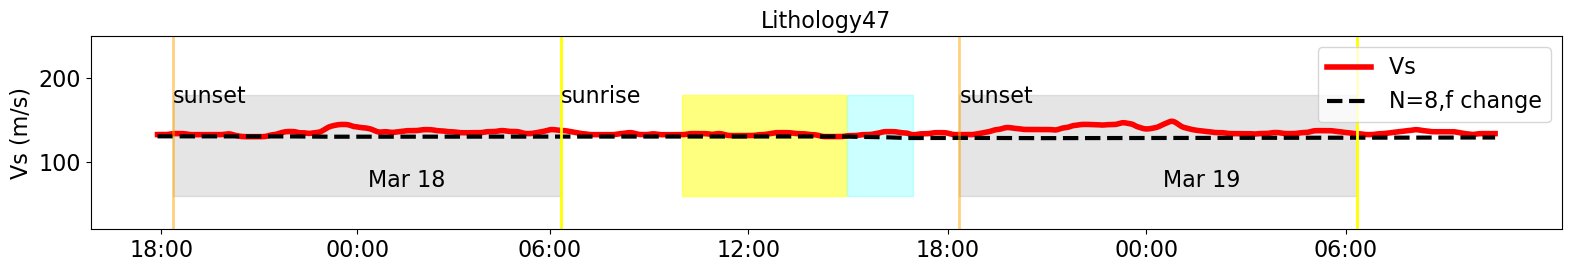

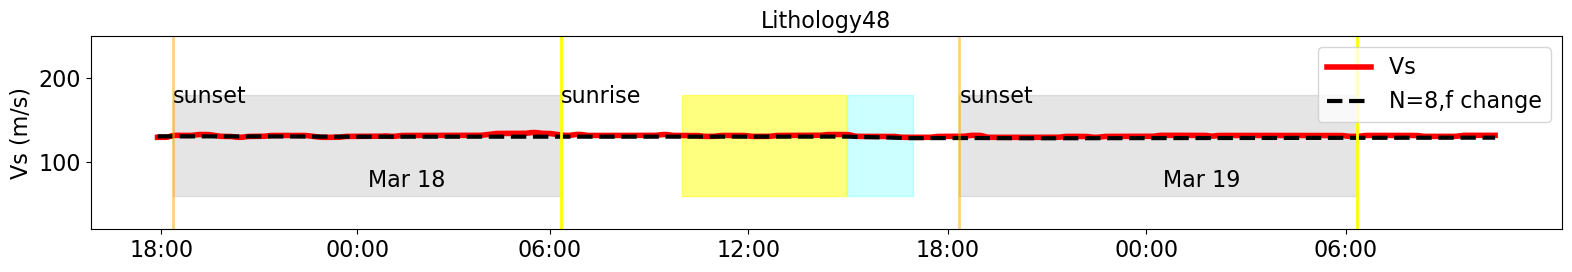

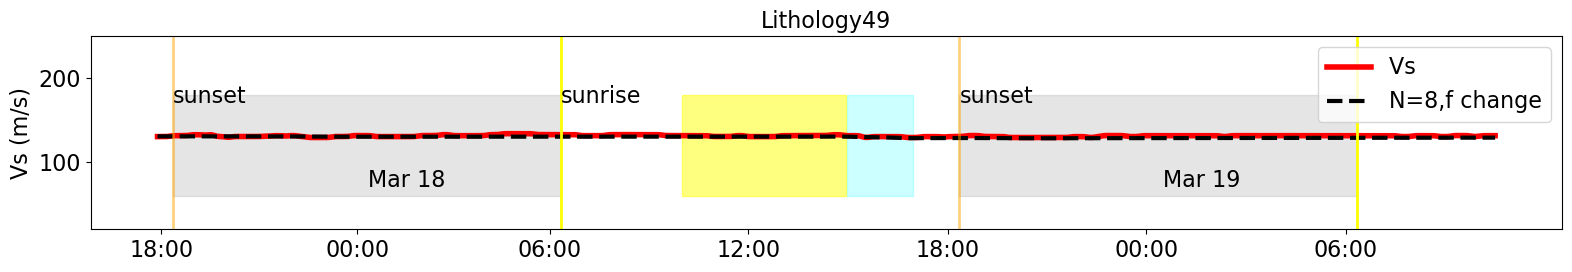

In [ ]:
vs_ref = []

for iloc in np.arange(6,50):
    A_e = 0.9
    A_d = 0
    A_p = 0.12

    ## Model the water balance
    s_history = hydro0(res_psd*2, 0.5, interp_humidity[0]/100-0.05, interp_temp10, 9, eto_every_minute, damage_index[iloc-6], A_p,A_e,A_d).get_s_history()
    s_history_smooth = gaussian_filter1d(s_history, sigma=25, mode='reflect')

    ## Model the lithology
    s_wr = 0.3  ## residual saturation
    s=interp_humidity/100
    scale_factor = (s_history_smooth+1)/2 * 3 - 0.6
    new_f = 0.9-scale_factor/2
    
    tau1 = 5e6 * np.exp(np.power(s_history_smooth[0:800],3))  ## wetting
    tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
    tau3 = 5e6 * np.exp(np.power(s_history_smooth[1250:1900],3))  ## wetting
    tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
    tau = np.concatenate((tau1, tau2, tau3, tau4))

    s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second
    p_diff = 0-np.concatenate((s_rate, [0])) * tau

    bulk_density, porosity = interp_bulk_density_30cm[iloc]*1000, interp_porosity_30cm[iloc]/100
    vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()

    vs_clay_ref = np.mean(vs_clay[150:210])
    vs_ref.append(vs_clay_ref)
    vs_correction = vs_clay_ref - np.mean((dvv_all[iloc, 150:210]+1)*108)

    ### Plot the water balance
    fig, ax2 = plt.subplots(1, 1, figsize=(16, 3), tight_layout=True)

    # Lithology plot
    ax2.fill_between(np.arange(2408), 60, 180, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
    ax2.fill_between([1240,1360], [60,60], [180,180], color='cyan', alpha=0.2)
    ax2.fill_between([27,726], [60,60], [180,180], color='gray', alpha=0.2)
    ax2.fill_between([1443,2158], [60,60], [180,180], color='gray', alpha=0.2)
    # ax2.plot(np.arange(2408), dvv*135, label='org_Vs', lw=2, color='b')
    ax2.plot(np.arange(2408), (dvv_all[iloc]+1)*108 + vs_correction, label='Vs ', lw=4, color='r')
    ax2.plot(np.arange(2408), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')
    ax2.set_ylabel("Vs (m/s)", fontsize=16)
    ax2.set_title("Lithology"+str(iloc), fontsize=16)
    ax2.set_xticks(xax)
    ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
    ax2.legend(loc='upper right')
    ax2.set_ylim(20, 250)
    ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.text(27, 170, 'sunset', color='k')
    ax2.text(726, 170, 'sunrise', color='k')
    ax2.text(1443, 170, 'sunset', color='k')
    # ax2.text(2158, 220, 'sunrise', color='k')
    ax2.text(Ind6hrs[1] + 20, 70, 'Mar 18', color='k')
    ax2.text(Ind6hrs[5] + 30, 70, 'Mar 19', color='k')


    plt.tight_layout()
    plt.show()

# Inversions

### Step 1: lithological

In [ ]:
## Forward model predicting next-minute velocity
class litho_1:
    def __init__(self, bulk_density, porosity, N, f, s0, s_rate, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s0 = s0  ## Saturation from the previous minute
        self.s_rate = s_rate ## rate per sec
        self.s = self.s0 + self.s_rate * 60 ## Saturation at the current minute
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            P_cdiff = self.s_rate * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5
        

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)
    

        return self.vp, self.vs, self.K, self.G, self.rho, self.s

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_9729/2494170393.py:43: RuntimeWarning: invalid value encountered in scalar power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_9729/2494170393.py:51: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


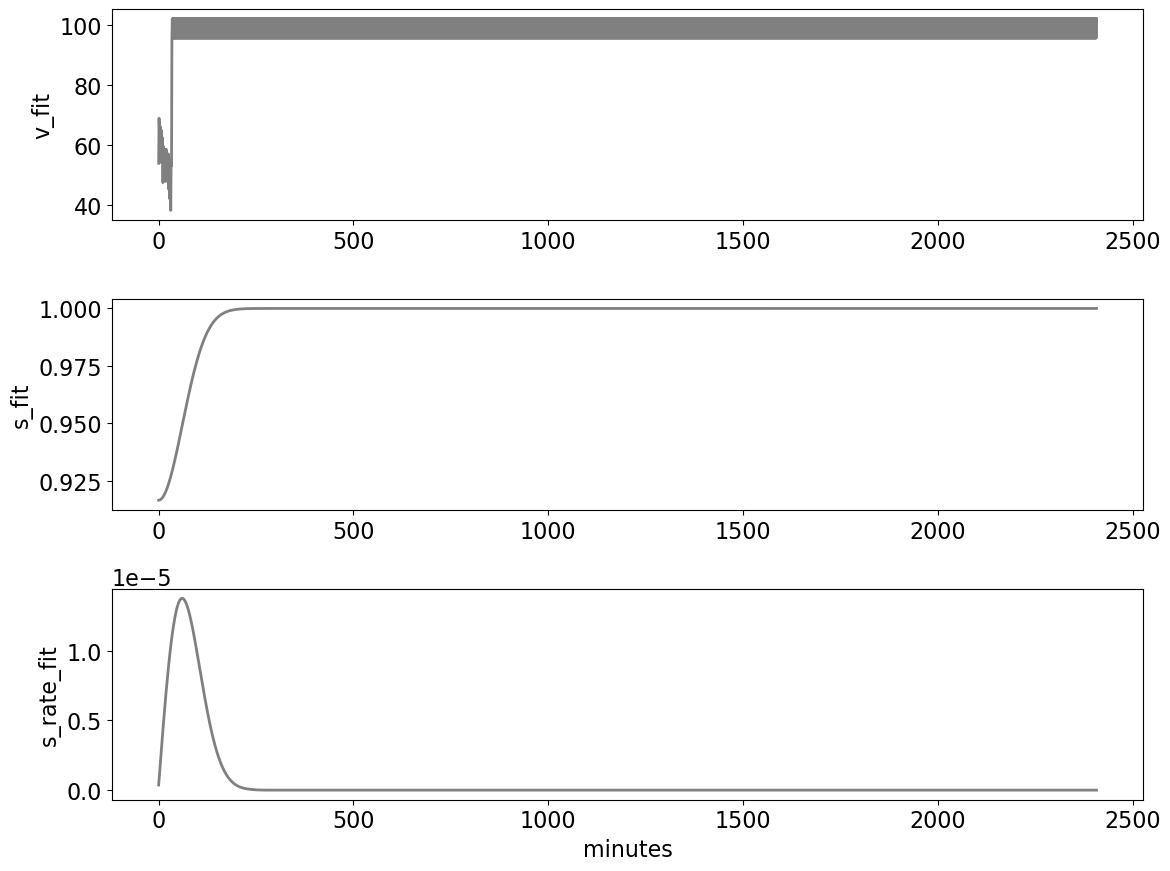

In [ ]:
s0 = 0.5
v = []
s_rate_inv = []
s_inv = []

dvv = dvv_all[18]
dvv_smooth = gaussian_filter1d(dvv, sigma=30, mode='reflect')

for i in range(2408):
    ds_space = np.arange(-0.02, 0.02, 0.0001)
    obj_func = np.zeros_like(ds_space)
    vs_clay = np.zeros_like(ds_space)
    s_rates = np.zeros_like(ds_space)
    for ii, ds in enumerate(ds_space):
        s = ds  + s0
        if s < 0:
            s = 0
        if s > 1:
            s = 1
        s_rates[ii] = (s - s0) / 60
        
        scale_factor = (s+1)/2 * 3 - 0.6
        new_f = 0.9-scale_factor/2

        if s_rates[ii] > 0:
            tau = 5e6 * np.exp(np.power(s,3))  ## wetting
        else:
            tau = 1e7 * (1-s)  ## drying

        _, vs_clay[ii],   _, _, _, _ = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[ii], s_wr, tau).get_vp_vs()
        obj_func[ii] = (dvv_smooth[i]*135 - vs_clay[ii]) ** 2

    best_idx = np.argmin(obj_func)
    if np.isnan(vs_clay[best_idx]):
        best_idx = np.nanargmin(obj_func)

    s = s0 + s_rates[best_idx] * 60
    scale_factor = (s+1)/2 * 3 - 0.6
    new_f = 0.9-scale_factor/2

    if s_rates[ii] > 0:
        tau = 5e6 * np.exp(np.power(s,3))  ## wetting
    else:
        tau = 1e7 * (1-s)  ## drying


    _, vs_best,   _, _, _, s0 = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[best_idx], s_wr, tau).get_vp_vs()

    v.append(vs_best)
    s_rate_inv.append(s_rates[best_idx])
    s_inv.append(s0)

s_inv_smooth = gaussian_filter1d(s_inv, sigma=60, mode='reflect')
s_rate_inv_smooth = np.append(np.diff(s_inv_smooth) / 60, [0])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)

# Plot v_fit
ax1.plot(np.arange(2408), v, label='v_fit', color='gray', lw=2)
ax1.set_ylabel("v_fit", fontsize=16)

# Plot s_rate_fit
ax2.plot(np.arange(2408), s_inv_smooth, label='s_fit', color='gray', lw=2)
ax2.set_ylabel("s_fit", fontsize=16)

# Plot s_fit
ax3.plot(np.arange(2408), s_rate_inv_smooth, label='s_rate_fit', color='gray', lw=2)
ax3.set_ylabel("s_rate_fit", fontsize=16)
ax3.set_xlabel("minutes", fontsize=16)

plt.show()


### Step 2: hydrological

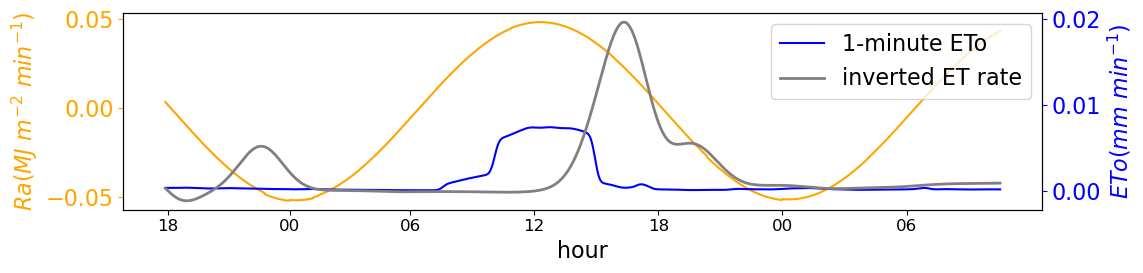

In [ ]:
### Backward model using s_history to calculate the ET rate
class hydro1:
    def __init__(self, prec, s_inv, s_rate_inv, damage_index, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.damage = damage_index
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length


    def get_evap(self):
        prec_rate = self.A_p * self.prec

        ## drainage
        drain_rate = self.A_d * self.prec * self.s * self.damage  ## Drainage rate

        evap_rate = prec_rate - drain_rate - self.s_rate

        ## evaporation
        self.evap = evap_rate / self.A_e 
        self.etc = self.evap / (self.s * self.damage) ## Evaporation rate
        
        return self.etc
    

A_e = 1
A_d = 0.1
A_p = 0.22

psd_smooth = gaussian_filter1d(ave_psd*2, sigma=60, mode='reflect')
etc_rate = hydro1(psd_smooth, s_inv_smooth, s_rate_inv_smooth * 60, damage_index[10], A_p,A_e,A_d).get_evap()
etc_smooth = gaussian_filter1d(etc_rate, sigma=1, mode='reflect')
eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=10, mode='reflect')

fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax1.set_xlabel("hour", fontsize=16)
ax1.set_ylabel("$Ra (MJ~m^{-2}~min^{-1})$", fontsize=16, color='orange')
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.tick_params(axis='y', colors='orange')

ax2 = ax1.twinx()
ax2.plot(np.arange(acqu_time.shape[0]), eto_every_minute_smooth, label='1-minute ETo', color='blue')
ax2.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16, color='blue')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.plot(np.arange(2408), etc_smooth, label='inverted ET rate', color='gray', lw=2)

plt.legend()

fig.tight_layout()
plt.show()

2347
1.5012511314012258 0.18316316122534215


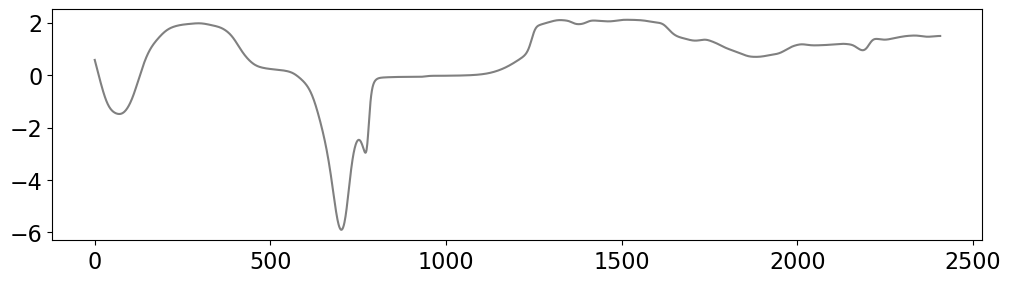

In [ ]:

### Backward model using s_history to calculate the Damage index
class hydro2:
    def __init__(self, prec, s_inv, s_rate_inv, etc, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.etc = etc
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length


    def get_damage(self):
    
        self.damage = (self.A_p * self.prec  - self.s_rate) / self.s / (self.A_e * self.etc + self.A_d * self.prec)

        i_peak_loss_rate = np.argmin(self.s_rate)
        print(i_peak_loss_rate)

        return self.damage, self.damage[i_peak_loss_rate]
    

A_e = 1
A_d = 0.1
A_p = 0.22

psd_smooth = gaussian_filter1d(ave_psd*2, sigma=60, mode='reflect')
damage_index, damage_index_peak = hydro2(psd_smooth, s_inv_smooth, s_rate_inv_smooth * 60, eto_every_minute_smooth, A_p,A_e,A_d).get_damage()
plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), damage_index, label='damage index', color='gray')
print(damage_index_peak, np.median(damage_index[1000:1300]))